In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(rc = {'figure.figsize':(12,5)})
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
# warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv('players_stats_by_season_full_details.csv')
data.head()

League       Season           Stage            Player Team  GP     MIN  FGM  \
0    NBA  1999 - 2000  Regular_Season  Shaquille O'Neal  LAL  79  3163.0  956   
1    NBA  1999 - 2000  Regular_Season      Vince Carter  TOR  82  3126.0  788   
2    NBA  1999 - 2000  Regular_Season       Karl Malone  UTA  82  2947.0  752   
3    NBA  1999 - 2000  Regular_Season     Allen Iverson  PHI  70  2853.0  729   
4    NBA  1999 - 2000  Regular_Season       Gary Payton  SEA  82  3425.0  747   

    FGA  3PM  ...    birth_date  height  height_cm  weight  weight_kg  \
0  1665    0  ...   Mar 6, 1972     7-1      216.0   325.0      147.0   
1  1696   95  ...  Jan 26, 1977     6-6      198.0   220.0      100.0   
2  1476    2  ...  Jul 24, 1963     6-9      206.0   265.0      120.0   
3  1733   89  ...   Jun 7, 1975     6-0      183.0   165.0       75.0   
4  1666  177  ...  Jul 23, 1968     6-4      193.0   180.0       82.0   

     nationality                  high_school  draft_round  draft_pick  \
0  United States  Robert G. Cole High School           1.0         1.0   
1  United States         Mainland High School          1.0         5.0   
2  United States      Summerfield High School          1.0        13.0   
3  United States          Bethel High School           1.0         1.0   
4  United States          Skyline High School          1.0         2.0   

              draft_team  
0          Orlando Magic  
1  Golden State Warriors  
2              Utah Jazz  
3    Philadelphia Sixers  
4    Seattle SuperSonics  

[5 rows x 34 columns]

In [3]:
# shape of the data
data.shape

(53949, 34)

In our dataset, there are multiple basketball leagues, but our primary focus is the NBA. However, since we are analyzing the histogram stats for players, we also want to capture the performance of NBA players who have played in other leagues. Additionally, we are interested in the stats of players who were born in the United States but did not play in the NBA, instead playing in various international leagues.

This approach allows us to analyze:

  - **NBA Players Who Have Played in Other Leagues:** By extracting players who have been part of the NBA and have also played in international leagues, we can analyze their performance across different competition levels and understand the factors that make them successful in multiple leagues.
  

  - **U.S.-Born Players Who Played Exclusively in International Leagues:** We include players born in the United States who, for various reasons, did not make it to the NBA but instead built their careers in international leagues. This group provides valuable insight into the performance and potential of U.S.-born players in foreign leagues, and how their stats compare to NBA players.

In [4]:
df =data.copy()
# Step 1: Filter NBA Players
nba_players = data[df["League"] == "NBA"]

# Step 2: Identify Players Who Have Played in Other Leagues
# Find unique players in NBA and check if they have played in another league
international_players = df[df["Player"].isin(nba_players["Player"]) & (df["League"] != "NBA")]

# Step 2: Identify players who are born in the USA and played in international leagues
us_born_international_players = df[(df["League"] != "NBA") & (df["nationality"] == "United States")]


# Merge NBA stats with International League stats (keeping all instances of the players)
# Step 3: Merge NBA and International Data for the same player (keeping all NBA rows)
merged_df = pd.concat([nba_players, international_players, us_born_international_players])

# Reset index of the merged DataFrame
merged_df.reset_index(drop=True, inplace=True)
merged_df.head()

League       Season           Stage            Player Team  GP     MIN  FGM  \
0    NBA  1999 - 2000  Regular_Season  Shaquille O'Neal  LAL  79  3163.0  956   
1    NBA  1999 - 2000  Regular_Season      Vince Carter  TOR  82  3126.0  788   
2    NBA  1999 - 2000  Regular_Season       Karl Malone  UTA  82  2947.0  752   
3    NBA  1999 - 2000  Regular_Season     Allen Iverson  PHI  70  2853.0  729   
4    NBA  1999 - 2000  Regular_Season       Gary Payton  SEA  82  3425.0  747   

    FGA  3PM  ...    birth_date  height  height_cm  weight  weight_kg  \
0  1665    0  ...   Mar 6, 1972     7-1      216.0   325.0      147.0   
1  1696   95  ...  Jan 26, 1977     6-6      198.0   220.0      100.0   
2  1476    2  ...  Jul 24, 1963     6-9      206.0   265.0      120.0   
3  1733   89  ...   Jun 7, 1975     6-0      183.0   165.0       75.0   
4  1666  177  ...  Jul 23, 1968     6-4      193.0   180.0       82.0   

     nationality                  high_school  draft_round  draft_pick  \
0  United States  Robert G. Cole High School           1.0         1.0   
1  United States         Mainland High School          1.0         5.0   
2  United States      Summerfield High School          1.0        13.0   
3  United States          Bethel High School           1.0         1.0   
4  United States          Skyline High School          1.0         2.0   

              draft_team  
0          Orlando Magic  
1  Golden State Warriors  
2              Utah Jazz  
3    Philadelphia Sixers  
4    Seattle SuperSonics  

[5 rows x 34 columns]

In [5]:
# shape of the data
merged_df.shape

(21834, 34)

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21834 entries, 0 to 21833
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   League       21834 non-null  object 
 1   Season       21834 non-null  object 
 2   Stage        21834 non-null  object 
 3   Player       21834 non-null  object 
 4   Team         21832 non-null  object 
 5   GP           21834 non-null  int64  
 6   MIN          21834 non-null  float64
 7   FGM          21834 non-null  int64  
 8   FGA          21834 non-null  int64  
 9   3PM          21834 non-null  int64  
 10  3PA          21834 non-null  int64  
 11  FTM          21834 non-null  int64  
 12  FTA          21834 non-null  int64  
 13  TOV          21834 non-null  int64  
 14  PF           21834 non-null  int64  
 15  ORB          21834 non-null  int64  
 16  DRB          21834 non-null  int64  
 17  REB          21834 non-null  int64  
 18  AST          21834 non-null  int64  
 19  STL 

In [7]:
merged_df.head()

League       Season           Stage            Player Team  GP     MIN  FGM  \
0    NBA  1999 - 2000  Regular_Season  Shaquille O'Neal  LAL  79  3163.0  956   
1    NBA  1999 - 2000  Regular_Season      Vince Carter  TOR  82  3126.0  788   
2    NBA  1999 - 2000  Regular_Season       Karl Malone  UTA  82  2947.0  752   
3    NBA  1999 - 2000  Regular_Season     Allen Iverson  PHI  70  2853.0  729   
4    NBA  1999 - 2000  Regular_Season       Gary Payton  SEA  82  3425.0  747   

    FGA  3PM  ...    birth_date  height  height_cm  weight  weight_kg  \
0  1665    0  ...   Mar 6, 1972     7-1      216.0   325.0      147.0   
1  1696   95  ...  Jan 26, 1977     6-6      198.0   220.0      100.0   
2  1476    2  ...  Jul 24, 1963     6-9      206.0   265.0      120.0   
3  1733   89  ...   Jun 7, 1975     6-0      183.0   165.0       75.0   
4  1666  177  ...  Jul 23, 1968     6-4      193.0   180.0       82.0   

     nationality                  high_school  draft_round  draft_pick  \
0  United States  Robert G. Cole High School           1.0         1.0   
1  United States         Mainland High School          1.0         5.0   
2  United States      Summerfield High School          1.0        13.0   
3  United States          Bethel High School           1.0         1.0   
4  United States          Skyline High School          1.0         2.0   

              draft_team  
0          Orlando Magic  
1  Golden State Warriors  
2              Utah Jazz  
3    Philadelphia Sixers  
4    Seattle SuperSonics  

[5 rows x 34 columns]

### Check for duplicates

In [8]:
# Define the stat columns based on your dataset
stat_columns = ['Player', 'League', 'Season', 'Stage','Team', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'TOV', 'PF', 'ORB', 'DRB']
stat_columns = merged_df.columns.tolist()

# Find duplicates based on player name and season
duplicates_by_player_season = merged_df[merged_df.duplicated(subset=stat_columns, keep=False)]
duplicates_by_player_season

League       Season          Stage            Player Team  GP  \
7637    Euroleague  2000 - 2001  International      Mike Batiste  SPI  10   
7649    Euroleague  2001 - 2002  International    Anthony Parker  MAC  12   
7664       Eurocup  2002 - 2003  International     Udonis Haslem  CHA   9   
7665       Eurocup  2002 - 2003  International    Michael Ruffin  PPL  14   
7668    Euroleague  2002 - 2003  International     Maurice Evans  OLY  17   
...            ...          ...            ...               ...  ...  ..   
21790  Turkish-BSL  2019 - 2020  International        D.J. White  TOF  20   
21791  Turkish-BSL  2019 - 2020  International  Derrick Williams  FEN  17   
21799  Turkish-BSL  2019 - 2020  International   Chris Singleton  EFE  13   
21801  Turkish-BSL  2019 - 2020  International    James Anderson  EFE  12   
21804  Turkish-BSL  2019 - 2020  International      James McAdoo  BES  11   

         MIN  FGM  FGA  3PM  ...    birth_date  height  height_cm  weight  \
7637   286.0   66  132    3  ...  Nov 21, 1977     6-8      203.0   225.0   
7649   419.4   65  139   11  ...  Jun 19, 1975     6-6      198.0   215.0   
7664   237.0   43   68    0  ...   Jun 9, 1980     6-8      203.0   235.0   
7665   393.0   46   82    0  ...  Jan 21, 1977     6-9      206.0   245.0   
7668   548.0   93  226   21  ...   Nov 8, 1978     6-5      196.0   220.0   
...      ...  ...  ...  ...  ...           ...     ...        ...     ...   
21790  442.8   62  122   24  ...  Aug 31, 1986     6-9      206.0   250.0   
21791  421.8   67  147   25  ...  May 25, 1991     6-8      203.0   240.0   
21799  373.3   43   91   20  ...  Nov 21, 1989     6-8      203.0   228.0   
21801  247.0   40   87   24  ...  Mar 25, 1989     6-6      198.0   210.0   
21804  227.8   42   68    0  ...   Jan 4, 1993     6-9      206.0   230.0   

       weight_kg    nationality                     high_school  draft_round  \
7637       102.0  United States    Wilson Classical High School          NaN   
7649        98.0  United States  Naperville Central High School          1.0   
7664       107.0  United States               Miami High School          NaN   
7665       111.0  United States        Cherry Creek High School          2.0   
7668       100.0  United States       Wichita Collegiate School          NaN   
...          ...            ...                             ...          ...   
21790      113.0  United States           Hillcrest High School          1.0   
21791      109.0  United States           La Mirada High School          1.0   
21799      103.0  United States            Cherokee High School          1.0   
21801       95.0  United States       Junction City High School          1.0   
21804      104.0  United States               Norfolk Christian          NaN   

       draft_pick              draft_team  
7637          NaN                     NaN  
7649         21.0         New Jersey Nets  
7664          NaN                     NaN  
7665          3.0           Chicago Bulls  
7668          NaN                     NaN  
...           ...                     ...  
21790        29.0         Detroit Pistons  
21791         2.0  Minnesota Timberwolves  
21799        18.0      Washington Wizards  
21801        20.0       San Antonio Spurs  
21804         NaN                     NaN  

[1112 rows x 34 columns]

Getting 1112 duplicated rows even when using all columns as stat_columns indicates that there are completely identical entries in your dataset. This means:

1. Data quality issue: You have exact duplicates of entire rows in your dataset6.
2. Potential causes:
     - Data entry errors: Accidental duplication during data collection or processing2.
     - System glitches: Issues with data import or export processes.
     - Intentional duplicates: In some cases, duplicates might represent legitimate repeated events, though this is less likely given the nature of basketball statistics.


In [9]:
# Remove duplicates
df_no_dup = merged_df.drop_duplicates(subset=stat_columns, 
                                                    keep='first')

In [10]:
df_no_dup.shape #shape of data after dropping duplicates values

(21278, 34)

In [11]:
# check for missing values
for i in df_no_dup.columns:
    if df_no_dup[i].isnull().sum() > 0:
        print(f"{i}: {df_no_dup[i].isnull().sum()} ")

Team: 2 
birth_year: 102 
birth_month: 102 
birth_date: 102 
height: 1 
height_cm: 1 
weight: 148 
weight_kg: 148 
high_school: 1900 
draft_round: 12529 
draft_pick: 12529 
draft_team: 12529 


there are significant missing values in the data, 

## Dealing with missing values

**Team:**
    Upon inspecting the data, we noticed that the rows with missing values in the "Team" column correspond to two players, Brandon Penn and Wesley Myers, who both played in the Serbian-KLS league during the 2019-2020 season. After checking the website, we found that both players were part of the KK Kolubara team during that period. As a result, we decided to fill the missing values in the "Team" column with the information 'KK' to accurately represent these players' team affiliation.

In [12]:
df_no_dup[df_no_dup['Team'].isnull()]

League       Season          Stage        Player Team  GP    MIN  \
21591  Serbian-KLS  2019 - 2020  International  Brandon Penn  NaN  11  344.4   
21592  Serbian-KLS  2019 - 2020  International  Wesley Myers  NaN  18  306.5   

       FGM  FGA  3PM  ...    birth_date  height  height_cm  weight  weight_kg  \
21591   70  155   30  ...   Jun 5, 1990     6-7      201.0   205.0       93.0   
21592   50  110   10  ...  May 25, 1995     6-1      185.0   193.0       88.0   

         nationality               high_school  draft_round  draft_pick  \
21591  United States  Paul Robeson High School          NaN         NaN   
21592  United States  Boys & Girls High School          NaN         NaN   

       draft_team  
21591         NaN  
21592         NaN  

[2 rows x 34 columns]

In [13]:
# Fill missing values in 'Team' column with 'KK'
df_no_dup['Team'] = df_no_dup['Team'].fillna('KK')

# Fill missing values in 'high_school' with 'unknown'
df_no_dup['high_school'] = df_no_dup['high_school'].fillna('Unknown')

In [14]:
df_no_dup[df_no_dup['birth_year'].isnull()]

League       Season          Stage              Player  \
8936              Euroleague  2000 - 2001  International  Richard Mandeville   
9306          Australian-NBL  2004 - 2005  International        Lamont Evans   
9482              German-BBL  2004 - 2005  International        Lamont Evans   
12373           Mexican-LNBP  2011 - 2012  International        David Mercer   
12826           Canadian-NBL  2012 - 2013  International    Sylvania Watkins   
...                      ...          ...            ...                 ...   
21607    Slovakian-Extraliga  2019 - 2020  International    Mason Stuteville   
21608    Slovakian-Extraliga  2019 - 2020  International         Jason Dunne   
21615    Slovakian-Extraliga  2019 - 2020  International          Marty Hill   
21616    Slovakian-Extraliga  2019 - 2020  International    Daquaise Andrews   
21818  Ukrainian-Superleague  2019 - 2020  International       Eddie Simmons   

       Team  GP     MIN  FGM  FGA  3PM  ...  birth_date  height  height_cm  \
8936    ZAD  10   181.1   28   50    0  ...         NaN     7-0      213.0   
9306   SCHW  23   493.8   26   69    6  ...         NaN     6-4      193.0   
9482   SCHW  23   493.8   26   69    6  ...         NaN     6-4      193.0   
12373   AGU  27   785.2  142  255    7  ...         NaN     NaN        NaN   
12826   MON  42  1312.7  155  372    4  ...         NaN     6-9      206.0   
...     ...  ..     ...  ...  ...  ...  ...         ...     ...        ...   
21607  SVIT  27   599.5  113  239   10  ...         NaN    6-11      211.0   
21608  LUCE  28   566.6   96  229   57  ...         NaN     6-4      193.0   
21615  PATR  20   321.6   34  100   16  ...         NaN     6-5      196.0   
21616  SVIT  11   257.6   29   79    2  ...         NaN     6-2      188.0   
21818  ZNTU  15   403.1   91  166    0  ...         NaN     6-3      191.0   

       weight  weight_kg    nationality                   high_school  \
8936    264.0      120.0  United States                       Unknown   
9306    185.0       84.0  United States                       Unknown   
9482    185.0       84.0  United States                       Unknown   
12373     NaN        NaN  United States                       Unknown   
12826   220.0      100.0  United States    South Atlanta High School    
...       ...        ...            ...                           ...   
21607   235.0      107.0  United States        Casa Roble High School   
21608   185.0       84.0  United States  Matawan Regional High School   
21615   180.0       82.0  United States     Champlin Park High School   
21616   170.0       77.0  United States  Thomas Jefferson High School   
21818   195.0       88.0  United States       Crete-Monee High School   

       draft_round  draft_pick  draft_team  
8936           NaN         NaN         NaN  
9306           NaN         NaN         NaN  
9482           NaN         NaN         NaN  
12373          NaN         NaN         NaN  
12826          NaN         NaN         NaN  
...            ...         ...         ...  
21607          NaN         NaN         NaN  
21608          NaN         NaN         NaN  
21615          NaN         NaN         NaN  
21616          NaN         NaN         NaN  
21818          NaN         NaN         NaN  

[102 rows x 34 columns]

In [15]:
# Extracting the first year from the "Season" column (e.g., "1999 - 2000" → 1999)
df_no_dup["season_start_year"] = df_no_dup["Season"].str.split(" - ").str[0].astype(int)

In [16]:
# estimate the birth year for players
def fill_missing_birth_year(df):
    df = df_no_dup.copy()
    # Step 1: Fill missing birth_year based on player_name
    df['birth_year'] = df.groupby('Player')['birth_year'].transform(
        lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
    )
    
    # Step 2: For remaining missing values, group by nationality and season to find birth_year
    df['temp_birth_year'] = df.groupby(['nationality', 'Season'])['birth_year'].transform(
        lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
    )
    
    # Step 3: Fill missing birth_year for each player using the minimum season_start_year
    def fill_player_birth_year(group):
        if group['birth_year'].isnull().any():
            min_season = group['season_start_year'].min()
            birth_year = group.loc[group['season_start_year'] == min_season, 'temp_birth_year'].iloc[0]
            return group['birth_year'].fillna(birth_year)
        return group['birth_year']
    
    df['birth_year'] = df.groupby('Player').apply(fill_player_birth_year).reset_index(level=0, drop=True)
    
    # Remove temporary column
    df.drop('temp_birth_year', axis=1, inplace=True)
    
    # Optional: Fill any remaining NaN values with a placeholder or remove rows
    df['birth_year'] = df['birth_year'].fillna(-1)  # Or use df.dropna(subset=['birth_year'], inplace=True)
    
    return df

# Usage:
df_no_dup = fill_missing_birth_year(df_no_dup)


In [17]:
# Step 1: Fill missing weight (lbs) using mean of players with the same height & height_cm
df_no_dup["weight"] = df_no_dup.groupby(["height", "height_cm"])["weight"].transform(lambda x: x.fillna(x.mean()))

# Step 2: Convert weight (lbs) to kg where missing
df_no_dup["weight_kg"] = round(df_no_dup["weight"] * 0.453592,0)

# Step 3: Fill missing weight (kg) using mean of players with same height & height_cm
df_no_dup["weight_kg"] = df_no_dup.groupby(["height", "height_cm"])["weight_kg"].transform(lambda x: x.fillna(x.mean()))

# Step 4: Round to 0 decimal place
df_no_dup["weight"] = df_no_dup["weight"].round(0)
df_no_dup["weight_kg"] = df_no_dup["weight_kg"].round(0)

# Step 5: Replace any remaining missing values with overall mean
df_no_dup["weight"] = round(df_no_dup["weight"].fillna(df_no_dup["weight"].mean()),0)
df_no_dup["weight_kg"] = round(df_no_dup["weight_kg"].fillna(df_no_dup["weight_kg"].mean()),0)


# Step 5: Verify missing values
print(df_no_dup[["weight", "weight_kg"]].isnull().sum())

weight       0
weight_kg    0
dtype: int64


In [18]:
df_no_dup[df_no_dup['height'].isnull()]

League       Season          Stage        Player Team  GP    MIN  \
12373  Mexican-LNBP  2011 - 2012  International  David Mercer  AGU  27  785.2   

       FGM  FGA  3PM  ...  height  height_cm  weight  weight_kg  \
12373  142  255    7  ...     NaN        NaN   214.0       97.0   

         nationality  high_school  draft_round  draft_pick  draft_team  \
12373  United States      Unknown          NaN         NaN         NaN   

       season_start_year  
12373               2011  

[1 rows x 35 columns]

In [19]:
# filling missing values for height_cm
df_no_dup['height_cm'] = df_no_dup.groupby(['nationality', 'weight'])['height_cm'].transform(
        lambda x: x.fillna(x.median() if not x.empty else np.nan))

In [20]:
# Fill missing draft information for players from the United States or players in the NBA
df_no_dup.loc[((df_no_dup['nationality'] == 'United States') | 
               (df_no_dup['League'] == 'NBA')) & 
              (df_no_dup['draft_round'].isnull()), 'draft_round'] = 0

df_no_dup.loc[((df_no_dup['nationality'] == 'United States') | 
               (df_no_dup['League'] == 'NBA')) & 
              (df_no_dup['draft_pick'].isnull()), 'draft_pick'] = 0

df_no_dup.loc[((df_no_dup['nationality'] == 'United States') | 
               (df_no_dup['League'] == 'NBA')) & 
              (df_no_dup['draft_team'].isnull()), 'draft_team'] = 'Undrafted'


# Fill missing draft information for international players and doesnt play in the NBA
df_no_dup.loc[((df_no_dup['nationality'] != 'United States') | 
               (df_no_dup['League'] != 'NBA')) & 
              (df_no_dup['draft_round'].isnull()), 'draft_round'] = 0

df_no_dup.loc[((df_no_dup['nationality'] != 'United States') | 
               (df_no_dup['League'] != 'NBA')) & 
              (df_no_dup['draft_pick'].isnull()), 'draft_pick'] = 0

df_no_dup.loc[((df_no_dup['nationality'] != 'United States') | 
               (df_no_dup['League'] != 'NBA')) & 
              (df_no_dup['draft_team'].isnull()), 'draft_team'] = 'International'

# Verify the missing draft data for players from the United States or NBA
print(df_no_dup[['draft_round', 'draft_pick', 'draft_team']].isnull().sum())


draft_round    0
draft_pick     0
draft_team     0
dtype: int64


In [21]:
# drop some columns
basketball = df_no_dup.drop(['height','birth_month','birth_date'], axis=1)

# check for missing values
basketball.isnull().sum()

League               0
Season               0
Stage                0
Player               0
Team                 0
GP                   0
MIN                  0
FGM                  0
FGA                  0
3PM                  0
3PA                  0
FTM                  0
FTA                  0
TOV                  0
PF                   0
ORB                  0
DRB                  0
REB                  0
AST                  0
STL                  0
BLK                  0
PTS                  0
birth_year           0
height_cm            0
weight               0
weight_kg            0
nationality          0
high_school          0
draft_round          0
draft_pick           0
draft_team           0
season_start_year    0
dtype: int64

In [22]:
basketball.duplicated().sum() # making sure no duplicates

0

In [23]:
df_clean = basketball.reset_index(drop=True)
df_clean.head()

League       Season           Stage            Player Team  GP     MIN  FGM  \
0    NBA  1999 - 2000  Regular_Season  Shaquille O'Neal  LAL  79  3163.0  956   
1    NBA  1999 - 2000  Regular_Season      Vince Carter  TOR  82  3126.0  788   
2    NBA  1999 - 2000  Regular_Season       Karl Malone  UTA  82  2947.0  752   
3    NBA  1999 - 2000  Regular_Season     Allen Iverson  PHI  70  2853.0  729   
4    NBA  1999 - 2000  Regular_Season       Gary Payton  SEA  82  3425.0  747   

    FGA  3PM  ...  birth_year  height_cm  weight  weight_kg    nationality  \
0  1665    0  ...      1972.0      216.0   325.0      147.0  United States   
1  1696   95  ...      1977.0      198.0   220.0      100.0  United States   
2  1476    2  ...      1963.0      206.0   265.0      120.0  United States   
3  1733   89  ...      1975.0      183.0   165.0       75.0  United States   
4  1666  177  ...      1968.0      193.0   180.0       82.0  United States   

                   high_school  draft_round  draft_pick  \
0  Robert G. Cole High School           1.0         1.0   
1         Mainland High School          1.0         5.0   
2      Summerfield High School          1.0        13.0   
3          Bethel High School           1.0         1.0   
4          Skyline High School          1.0         2.0   

              draft_team  season_start_year  
0          Orlando Magic               1999  
1  Golden State Warriors               1999  
2              Utah Jazz               1999  
3    Philadelphia Sixers               1999  
4    Seattle SuperSonics               1999  

[5 rows x 32 columns]

# Data Exploratory

In [24]:
# Compute Age at the start of the league
df_clean["age"] = df_clean["season_start_year"] - df_clean["birth_year"]

# Display the first few rows to verify changes
df_clean[["birth_year", "age"]].head()

birth_year   age
0      1972.0  27.0
1      1977.0  22.0
2      1963.0  36.0
3      1975.0  24.0
4      1968.0  31.0

In [25]:
df_clean.describe()

GP           MIN           FGM           FGA           3PM  \
count  21278.000000  21278.000000  21278.000000  21278.000000  21278.000000   
mean      35.041921    938.868865    153.412539    328.648698     33.761115   
std       23.498401    700.833342    132.478025    283.389334     38.617400   
min        1.000000      0.700000      0.000000      0.000000      0.000000   
25%       16.000000    402.225000     59.000000    129.000000      4.000000   
50%       31.000000    801.800000    122.000000    261.000000     21.000000   
75%       45.000000   1202.975000    198.000000    420.000000     50.000000   
max       85.000000   3485.000000    978.000000   2173.000000    402.000000   

                3PA           FTM           FTA           TOV            PF  \
count  21278.000000  21278.000000  21278.000000  21278.000000  21278.000000   
mean      93.900320     77.242034    102.888617     58.430398     81.622615   
std      101.504199     79.731596    101.780741     48.248696     58.553507   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       15.000000     26.000000     35.000000     23.000000     36.000000   
50%       64.000000     56.000000     76.000000     48.000000     71.000000   
75%      139.000000     99.000000    133.000000     78.000000    109.000000   
max     1028.000000    756.000000    972.000000    464.000000    371.000000   

       ...           BLK           PTS    birth_year     height_cm  \
count  ...  21278.000000  21278.000000  21278.000000  21278.000000   
mean   ...     16.060767    417.833584   1984.835135    198.075054   
std    ...     25.160053    359.789999      6.786811      8.909110   
min    ...      0.000000      0.000000   1961.000000    160.000000   
25%    ...      2.000000    164.000000   1980.000000    191.000000   
50%    ...      7.000000    335.000000   1986.000000    198.000000   
75%    ...     19.000000    537.000000   1990.000000    206.000000   
max    ...    307.000000   2832.000000   2001.000000    229.000000   

             weight     weight_kg   draft_round    draft_pick  \
count  21278.000000  21278.000000  21278.000000  21278.000000   
mean     214.421186     97.268117      0.541592      5.470533   
std       26.647936     12.098426      0.720479      8.507742   
min      135.000000     61.000000      0.000000      0.000000   
25%      195.000000     88.000000      0.000000      0.000000   
50%      215.000000     98.000000      0.000000      0.000000   
75%      235.000000    107.000000      1.000000      9.000000   
max      350.000000    159.000000      7.000000     30.000000   

       season_start_year           age  
count       21278.000000  21278.000000  
mean         2012.029467     27.194332  
std             5.545017      3.842932  
min          1999.000000     16.000000  
25%          2008.000000     24.000000  
50%          2013.000000     27.000000  
75%          2017.000000     30.000000  
max          2019.000000     45.000000  

[8 rows x 25 columns]

GP (Games Played):
The maximum value of 85 seems high, as NBA regular seasons typically have 82 games. This could be due to including playoff games or a data error. 

draft_round:
The maximum value of 7 is inconsistent with the current NBA draft format, which has only 2 rounds. 

In [26]:
# Correct GP (Games Played)
def correct_gp(gp):
    return 82 if gp > 82 else gp  # Fill values > 82 with 82

df_clean['GP'] = df_clean['GP'].apply(correct_gp)

# 2. Correct draft_round
def correct_draft_round(round):
    if pd.isna(round) or round == 0:
        return 0  # Undrafted or missing data
    elif round > 2:
        return 2  # Cap at 2 rounds
    else:
        return round

df_clean['draft_round'] = df_clean['draft_round'].apply(correct_draft_round)

In [27]:
df_clean[df_clean['age']<19]

League       Season          Stage  \
7642                    Euroleague  2000 - 2001  International   
7660                    Euroleague  2001 - 2002  International   
7663                       Eurocup  2002 - 2003  International   
7683                       Eurocup  2003 - 2004  International   
7710                   Spanish-ACB  2003 - 2004  International   
7733                    Euroleague  2004 - 2005  International   
7734                    Euroleague  2004 - 2005  International   
7736             French-Jeep-Elite  2004 - 2005  International   
7741   Italian-Lega-Basket-Serie-A  2004 - 2005  International   
7751                   Spanish-ACB  2004 - 2005  International   
7818                    Euroleague  2006 - 2007  International   
7819                    Euroleague  2006 - 2007  International   
7821             French-Jeep-Elite  2006 - 2007  International   
7826   Italian-Lega-Basket-Serie-A  2006 - 2007  International   
7839                   Spanish-ACB  2006 - 2007  International   
7848                       Eurocup  2007 - 2008  International   
7887                   Spanish-ACB  2007 - 2008  International   
7924                    Euroleague  2008 - 2009  International   
8031                    Euroleague  2010 - 2011  International   
8236         Austrian-A-Bundesliga  2013 - 2014  International   
8318                   Serbian-KLS  2013 - 2014  International   
8328                   Spanish-ACB  2013 - 2014  International   
8337         Ukrainian-Superleague  2013 - 2014  International   
8350             Croatian-A-1-Liga  2014 - 2015  International   
8352             Croatian-A-1-Liga  2014 - 2015  International   
8450             Croatian-A-1-Liga  2015 - 2016  International   
8485               FIBA-Europe-Cup  2015 - 2016  International   
8564                    Euroleague  2016 - 2017  International   
8573             French-Jeep-Elite  2016 - 2017  International   
8593                   Spanish-ACB  2016 - 2017  International   
8610                Australian-NBL  2017 - 2018  International   
8640                    Euroleague  2017 - 2018  International   
8665                    German-BBL  2017 - 2018  International   
8686                   Serbian-KLS  2017 - 2018  International   
8689                   Spanish-ACB  2017 - 2018  International   
18212                    Swiss-LNA  2017 - 2018  International   
19947                 Canadian-NBL  2019 - 2020  International   

                   Player   Team  GP     MIN  FGM  FGA  3PM  ...  height_cm  \
7642           Beno Udrih    OLI  13   319.8   36   78    5  ...      193.0   
7660         Nenad Krstic    PAR   6   125.0   13   25    0  ...      208.0   
7663        Sasha Vujacic    PAU  11   331.0   43   97   20  ...      201.0   
7683       Rudy Fernandez    JOV  14   385.0   47  102   21  ...      198.0   
7710       Rudy Fernandez    JOV  37  1041.5  138  298   55  ...      198.0   
7733     Sergio Rodriguez    EST  14   243.5   31   74    7  ...      191.0   
7734      Marco Belinelli    BOL  20   298.8   31   62   11  ...      196.0   
7736          Ian Mahinmi    SLH  33   555.0   75  131    0  ...      211.0   
7741      Marco Belinelli    BOL  44   778.0   98  210   47  ...      196.0   
7751     Sergio Rodriguez    EST  42   856.8  143  278   22  ...      191.0   
7818          Ricky Rubio    JOV  16   302.0   16   46    3  ...      193.0   
7819        Nicolas Batum    LEM  12   161.5   19   38    3  ...      203.0   
7821        Nicolas Batum    LEM  36   592.0   73  144   15  ...      203.0   
7826     Danilo Gallinari    MIL  41  1080.0  125  295   35  ...      208.0   
7839          Ricky Rubio    JOV  43   825.5   55  144   17  ...      193.0   
7848          Ricky Rubio    JOV  16   335.1   43   81    9  ...      193.0   
7887          Ricky Rubio    JOV  39   905.2  106  292   31  ...      193.0   
7924           Jan Vesely    PAR  17   338.8   30   58    1  ...      211.0   
8031    Jonas Vala

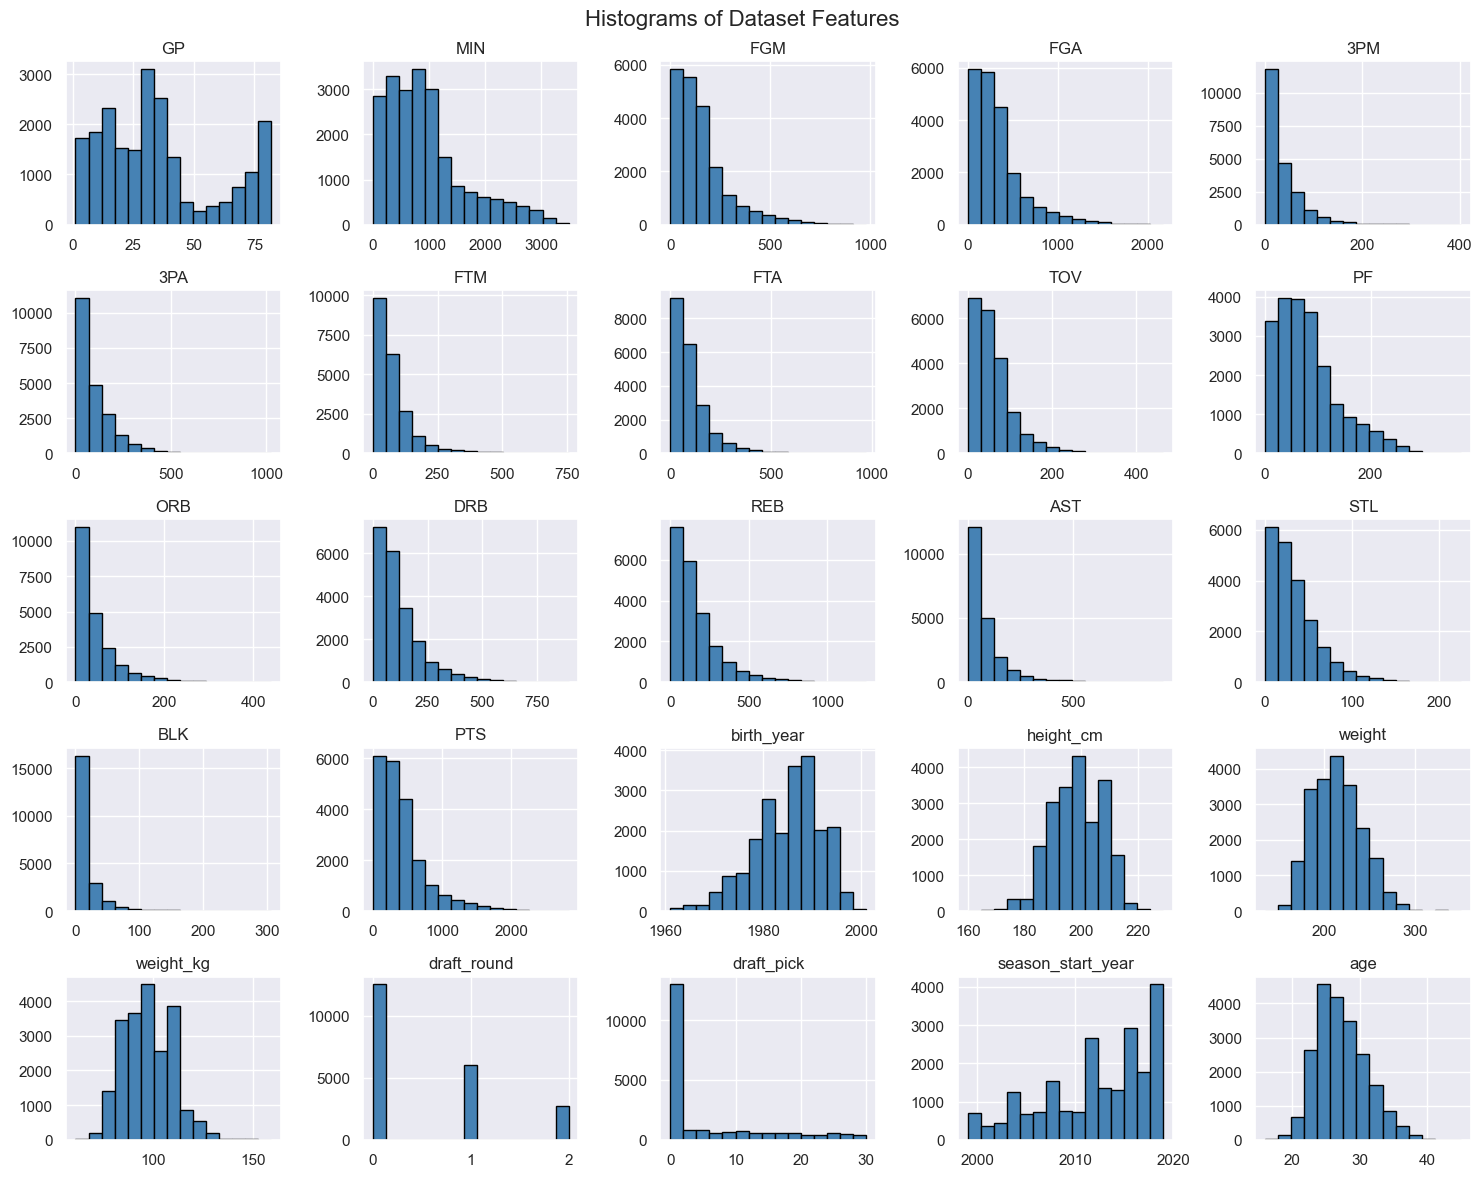

In [28]:
# Plot histograms for all features
df_clean.hist(figsize=(15, 12), bins=15, color="steelblue", edgecolor="black")
plt.suptitle("Histograms of Dataset Features", fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
df_clean[df_clean['PTS']>1000]

League       Season           Stage            Player  Team  GP  \
0              NBA  1999 - 2000  Regular_Season  Shaquille O'Neal   LAL  79   
1              NBA  1999 - 2000  Regular_Season      Vince Carter   TOR  82   
2              NBA  1999 - 2000  Regular_Season       Karl Malone   UTA  82   
3              NBA  1999 - 2000  Regular_Season     Allen Iverson   PHI  70   
4              NBA  1999 - 2000  Regular_Season       Gary Payton   SEA  82   
...            ...          ...             ...               ...   ...  ..   
19949  Chinese-CBA  2019 - 2020   International         Joe Young  TONG  44   
19950  Chinese-CBA  2019 - 2020   International         Kyle Fogg  BEIK  44   
19951  Chinese-CBA  2019 - 2020   International       Sonny Weems   GST  51   
19952  Chinese-CBA  2019 - 2020   International   Dominique Jones   JIL  28   
19953  Chinese-CBA  2019 - 2020   International      Darius Adams   QIN  29   

          MIN  FGM   FGA  3PM  ...  height_cm  weight  weight_kg  \
0      3163.0  956  1665    0  ...      216.0   325.0      147.0   
1      3126.0  788  1696   95  ...      198.0   220.0      100.0   
2      2947.0  752  1476    2  ...      206.0   265.0      120.0   
3      2853.0  729  1733   89  ...      183.0   165.0       75.0   
4      3425.0  747  1666  177  ...      193.0   180.0       82.0   
...       ...  ...   ...  ...  ...        ...     ...        ...   
19949  1782.0  617  1220  139  ...      188.0   185.0       84.0   
19950  1590.0  337   710   96  ...      191.0   183.0       83.0   
19951  1503.0  457   848   48  ...      198.0   205.0       93.0   
19952  1115.0  354   758   75  ...      193.0   215.0       98.0   
19953  1026.0  336   725  122  ...      185.0   165.0       75.0   

         nationality                  high_school  draft_round  draft_pick  \
0      United States  Robert G. Cole High School           1.0         1.0   
1      United States         Mainland High School          1.0         5.0   
2      United States      Summerfield High School          1.0        13.0   
3      United States          Bethel High School           1.0         1.0   
4      United States          Skyline High School          1.0         2.0   
...              ...                          ...          ...         ...   
19949  United States            Yates High School          2.0        13.0   
19950  United States      Brea Olinda High School          0.0         0.0   
19951  United States    West Memphis High School           2.0         9.0   
19952  United States       Lake Wales High School          1.0        25.0   
19953  United States        MacArthur High School          0.0         0.0   

                  draft_team  season_start_year   age  
0              Orlando Magic               1999  27.0  
1      Golden State Warriors               1999  22.0  
2                  Utah Jazz               1999  36.0  
3        Philadelphia Sixers               1999  24.0  
4        Seattle SuperSonics               1999  31.0  
...                      ...                ...   ...  
19949         Indiana Pacers               2019  27.0  
19950              Undrafted               2019  29.0  
19951          Chicago Bulls               2019  33.0  
19952      Memphis Grizzlies               2019  31.0  
19953              Undrafted               2019  30.0  

[1599 rows x 33 columns]

Some players' statistics are above average, while others fall below. In certain cases, the statistics are zero, which could imply a variety of factors. For example, a value of zero might indicate that the player did not participate in a particular category (e.g., no attempts in a specific stat like 3-point field goals or free throws), or it could suggest that the player did not accumulate any meaningful contributions in that stat during the season.

#### Players Performance metrics

In [30]:
df = df_clean.copy()

# Calculate shooting efficiency with division by zero handling
df['FG%'] = np.where(df['FGA'] == 0, np.nan, df['FGM'] / df['FGA'])  # Field Goal Percentage
df['3P%'] = np.where(df['3PA'] == 0, np.nan, df['3PM'] / df['3PA'])  # 3-Point Percentage
df['FT%'] = np.where(df['FTA'] == 0, np.nan, df['FTM'] / df['FTA'])  # Free Throw Percentage

# Calculate True Shooting Percentage (TS%) with division by zero handling
df['TS%'] = np.where((df['FGA'] + 0.44 * df['FTA']) == 0, np.nan, 
                     df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA'])))  # True Shooting Percentage

# Calculate Assist-to-Turnover Ratio with division by zero handling
df['AST_TO_Ratio'] = np.where(df['TOV'] == 0, np.nan, df['AST'] / df['TOV'])  # Assist-to-Turnover Ratio

# Per Game Stats Normalization with division by zero handling
for stat in ['PTS', 'REB', 'AST', 'STL', 'BLK']:
    df[f'{stat}_per_game'] = np.where(df['GP'] == 0, np.nan, df[stat] / df['GP'])  # Avoid division by zero when GP is zero


In [31]:
# Get an overview of the calculated metrics
df[['FG%', '3P%', 'FT%', 'TS%', 'AST_TO_Ratio', 'PTS_per_game', 
          'REB_per_game', 'AST_per_game', 'STL_per_game', 'BLK_per_game']].describe()


FG%           3P%           FT%           TS%  AST_TO_Ratio  \
count  21276.000000  19744.000000  21176.000000  21276.000000  21248.000000   
mean       0.466456      0.318696      0.743086      0.557126      1.385035   
std        0.073312      0.135468      0.119853      0.063261      0.847587   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.420635      0.279570      0.680000      0.520178      0.800000   
50%        0.458160      0.342857      0.757576      0.557482      1.240000   
75%        0.506329      0.389610      0.822222      0.595951      1.796875   
max        0.909091      1.000000      1.000000      0.900000     15.000000   

       PTS_per_game  REB_per_game  AST_per_game  STL_per_game  BLK_per_game  
count  21278.000000  21278.000000  21278.000000  21278.000000  21278.000000  
mean      11.864022      4.652969      2.288488      0.965484      0.426269  
std        5.287855      2.447668      1.707530      0.521542      0.475375  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        8.120303      2.851852      1.058824      0.594203      0.104441  
50%       11.309691      4.142857      1.800000      0.878049      0.267731  
75%       14.736842      5.973684      3.071429      1.250000      0.575000  
max       41.972222     18.666667     13.272727      4.300000      4.333333

**Shooting Percentages:**

   - FG% (Field Goal Percentage): The average is 46.6%, which is typical for NBA players. The best shooters (75th percentile) hit over 50.6% of their shots.
   - 3P% (3-Point Percentage): The average is 31.9%, with top shooters (75th percentile) hitting 38.9% or more from beyond the arc.
   - FT% (Free Throw Percentage): The average is 74.3%, with the best free throw shooters (75th percentile) making over 82.2% of their attempts.

**TS% (True Shooting Percentage):**

  - The average is 55.7%, which is a good efficiency rate.
  - The top 25% of players have a TS% of 59.6% or higher, indicating excellent scoring efficiency.

**AST_TO_Ratio (Assist to Turnover Ratio):**

  - The average is 1.39, meaning players generally create more assists than turnovers.
  - The top 25% have a ratio of 1.80 or higher, indicating excellent ball handling and decision-making.

**Per Game Statistics:**

  - PTS_per_game: The average is 11.86 points, with the top scorers (75th percentile) averaging 14.74 or more.
  - REB_per_game: The average is 4.65 rebounds, with top rebounders grabbing 5.97 or more.
  - AST_per_game: The average is 2.29 assists, with the best passers dishing out 3.07 or more.
  - STL_per_game and BLK_per_game: These have lower averages (0.97 and 0.43 respectively), which is expected as these are less common events.

**Variability:**

  - 3P% has the highest standard deviation relative to its mean, indicating a wide range of three-point shooting abilities.
  - BLK_per_game also shows high variability, suggesting significant differences in shot-blocking abilities among players.

**Extremes:**

  - The maximum values show some exceptional performances, like a player averaging nearly 42 points per game or 18.7 rebounds per game in a season.
  - The minimum values of 0 across all categories likely represent players with very limited playing time or those who didn't record any stats in certain categories.


These statistics provide a baseline for evaluating player performance and can be used to identify undervalued players or specific skills that might be overlooked in traditional analysis, aligning with the Moneyball approach.

In [32]:
# 1. Identify efficient scorers who might be undervalued
def find_efficient_scorers(df):
    efficient_scorers = df[(df['TS%'] > df['TS%'].quantile(0.75)) & 
                           (df['PTS_per_game'] > df['PTS_per_game'].mean()) &
                           (df['MIN'] < df['MIN'].median())]
    efficient_scorers['Efficiency'] = efficient_scorers['PTS_per_game'] / efficient_scorers['MIN']
    return efficient_scorers.sort_values('TS%', ascending=False)

# 2. Find good passers with low turnover rates
def find_good_passers(df):
    good_passers = df[(df['AST_per_game'] > df['AST_per_game'].quantile(0.75)) & 
                      (df['AST_TO_Ratio'] > df['AST_TO_Ratio'].quantile(0.75))]
    return good_passers.sort_values('AST_TO_Ratio', ascending=False)

# 3. Identify versatile players (good at multiple aspects)
def find_versatile_players(df):
    versatile_players = df[(df['PTS_per_game'] > df['PTS_per_game'].median()) &
                           (df['REB_per_game'] > df['REB_per_game'].median()) &
                           (df['AST_per_game'] > df['AST_per_game'].median()) &
                           (df['STL_per_game'] > df['STL_per_game'].median())]
    return versatile_players

# 4. Find undervalued three-point shooters
def find_three_point_specialists(df):
    three_point_specialists = df[(df['3P%'] > df['3P%'].quantile(0.75)) &
                                 (df['3PA'] > df['3PA'].median())]
    return three_point_specialists.sort_values('3P%', ascending=False)

# 5. Visualize the relationship between efficiency and volume
def plot_efficiency_vs_volume(df):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PTS_per_game', y='TS%', hue='MIN', size='MIN',
                    sizes=(20, 200), palette='viridis')
    plt.title('Scoring Efficiency vs Volume')
    plt.xlabel('Points per Game')
    plt.ylabel('True Shooting Percentage')
    plt.show()

# 6. Composite Score for overall value
def calculate_composite_score(df):
    df['Composite_Score'] = (
        df['PTS_per_game'].rank(pct=True) +
        df['TS%'].rank(pct=True) +
        df['AST_TO_Ratio'].rank(pct=True) +
        df['REB_per_game'].rank(pct=True) +
        df['STL_per_game'].rank(pct=True) +
        df['BLK_per_game'].rank(pct=True)
    ) / 6
    return df.sort_values('Composite_Score', ascending=False)

# Execute the functions
efficient_scorers = find_efficient_scorers(df)
good_passers = find_good_passers(df)
versatile_players = find_versatile_players(df)
three_point_specialists = find_three_point_specialists(df)

print("Top 10 Efficient Scorers:")
print(efficient_scorers[['Player', 'Team', 'TS%', 'PTS_per_game', 'MIN', "Efficiency"]].head(10))

print("\nTop 10 Good Passers:")
print(good_passers[['Player', 'Team', 'AST_per_game', 'AST_TO_Ratio']].head(10))

print("\nTop 10 Versatile Players:")
print(versatile_players[['Player', 'Team', 'PTS_per_game', 'REB_per_game', 'AST_per_game', 'STL_per_game']].head(10))

print("\nTop 10 Three-Point Specialists:")
print(three_point_specialists[['Player', 'Team', '3P%', '3PA']].head(10))


Top 10 Efficient Scorers:
                Player Team       TS%  PTS_per_game    MIN  Efficiency
8012     Primoz Brezec  KRY  0.855696     20.833333  183.8    0.113348
8855   Jimmer Fredette  PAN  0.824176     13.666667  342.3    0.039926
16474  D.J. Richardson  SPI  0.820611     21.500000   62.2    0.345659
20199      Jeff Withey  IRO  0.811924     14.888889  246.7    0.060352
16442      Seth Tuttle  LIM  0.782584     18.333333  178.5    0.102708
15525      Tony Gugino  RIL  0.774246     12.666667  182.6    0.069368
3006         Raja Bell  PHX  0.772025     13.600000  214.8    0.063315
16992   James Nunnally  FEN  0.771899     11.866667  635.1    0.018685
17516    Cory Bradford  BOS  0.770021     15.000000   92.4    0.162338
17544       Mike Myers  OOS  0.767045     13.500000   41.7    0.323741

Top 10 Good Passers:
                  Player Team  AST_per_game  AST_TO_Ratio
3708        Kirk Hinrich  CHI      4.000000     10.000000
7186         Patty Mills  SAS      3.571429      8.3333

**Undervalued Scorers**
- D.J. Richardson stands out with the highest efficiency at 0.345 PTS/MIN, scoring 21.5 points in just 62.2 minutes. He's a prime candidate for a high-impact player with limited court time, making him a valuable, potentially undervalued asset.

- Mike Myers (0.324 PTS/MIN) also demonstrates strong scoring efficiency in just 41.7 minutes, suggesting he could be a hidden gem if given more playtime.
- Primoz Brezec and Jimmer Fredette also make the list with strong TS%, though their efficiency per minute is lower compared to the top performers like Richardson and Myers.

- While players like Jimmer Fredette and James Nunnally contribute notable scoring, their lower efficiency relative to minutes played indicates they may not be as efficient as others on this list.

While many of the players on this list were not undervalued in terms of their efficiency, they were often underutilized or did not get the opportunity to showcase their skills at the highest levels of basketball, particularly in the NBA. Players like Jimmer Fredette and Jeff Withey had the potential to contribute more, but their careers didn’t fully reflect their statistical efficiency.

In a Moneyball context, these players would be considered undervalued assets for teams looking for efficient scoring or specific roles. They were often overlooked because they didn't fit conventional expectations of NBA stars, even though their efficiency metrics suggest they could have been much more impactful if given the right opportunities.

Thus, Moneyball strategies would suggest that players like Primoz Brezec and D.J. Richardson could have been used more effectively, especially for teams with limited resources looking to optimize efficiency.

**Good Passer**

- These players excel at playmaking, showcasing high assist-to-turnover ratios and strong assists per game, making them highly valuable for teams in need of playmaking and efficient ball distribution. John Stockton and Chris Paul are the top-tier passers. 
- While John Stockton and Chris Paul are certainly not overlooked given their established reputations as elite playmakers, players like **Kirk Hinrich, Patty Mills, and Maarty Leunen** are often the unsung heroes. These players may not receive as much spotlight, but their ability to distribute the ball efficiently and maintain solid assist-to-turnover ratios is incredibly valuable. 
- They provide teams with much-needed depth in playmaking and can act as reliable facilitators, especially in high-pressure situations where ball control is key. Their efficiency in distributing the ball can make a significant impact, contributing to a team's overall success without needing to dominate the scoring charts.


**versatile players**

Many of the top versatile players were often undervalued or overlooked for their contributions beyond scoring. Players like Vince Carter and Gary Payton, known for their offensive prowess and defense respectively, were sometimes not fully appreciated for their all-around skills during their time. Tim Duncan's leadership and defensive impact were crucial to the Spurs' success, but his quiet style of play often went under the radar compared to flashier stars. Despite their multifaceted contributions, these players were sometimes viewed as one-dimensional, missing out on the recognition they truly deserved. Teams looking to optimize their roster and cut costs could have greatly benefited from these players, who offered invaluable all-around skills at more affordable prices.

**Three-Point Specialists**

- This list highlights players who excelled in three-point shooting, an increasingly vital aspect of modern basketball. Specialists like Marcus Haislip and Jimmer Fredette were incredibly effective from beyond the arc. Haislip posted a remarkable 3P% of 65.0% on 160 attempts, while Fredette showcased a strong 3P% of 60.3%, albeit with fewer attempts (78). Their ability to stretch the floor and create scoring opportunities makes them valuable assets in today's up-tempo offenses.

- Haislip may have been overlooked due to his short NBA career and stints with lesser-known teams, despite his exceptional shooting efficiency. Similarly, Fredette, widely celebrated for his college career, struggled to carve out a consistent role in the NBA, resulting in his undervaluation despite his remarkable shooting talent. 
- Peyton Siva and James Nunnally, though productive overseas, weren’t able to break through as key NBA contributors, leaving them largely underappreciated despite their solid three-point shooting abilities. These players could have brought significant contributions, particularly in teams needing reliable shooters to space the floor.

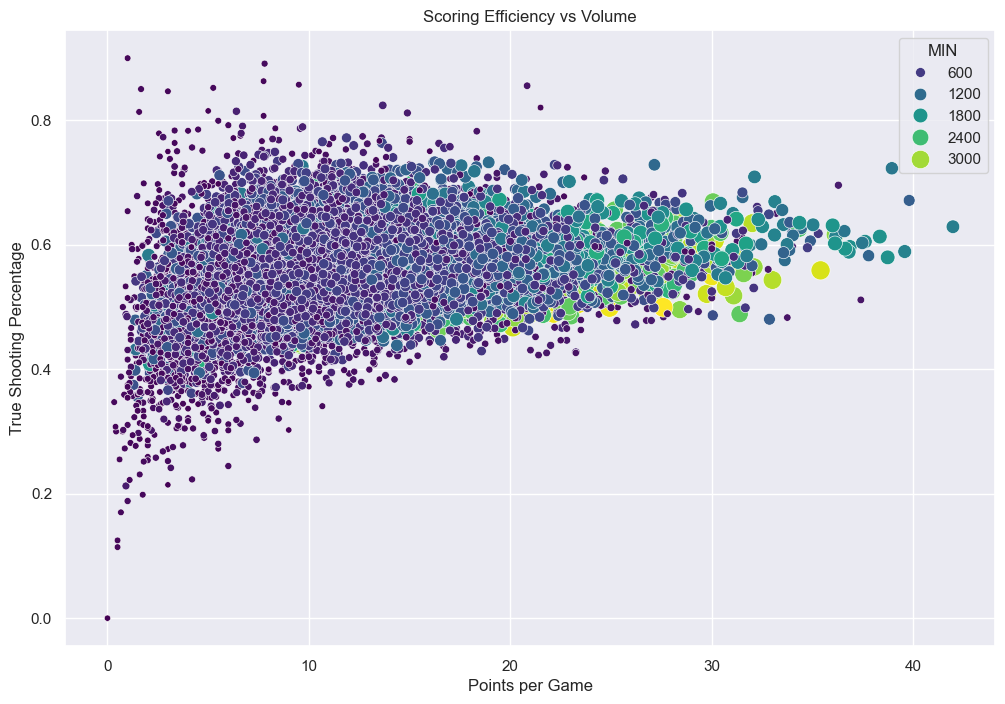

Player       Season       League  Team  Composite_Score  \
18568  Jamaal Franklin  2018 - 2019  Chinese-CBA  SICH         0.958169   
19957  Jamaal Franklin  2019 - 2020  Chinese-CBA   SZD         0.946184   
19468      William Lee  2018 - 2019  Serbian-KLS  DYNA         0.941037   
6195      LeBron James  2016 - 2017          NBA   CLE         0.926656   
16277  Jamaal Franklin  2016 - 2017  Chinese-CBA   SZD         0.921849   
14437    Lester Hudson  2014 - 2015  Chinese-CBA   LIA         0.916461   
4486      LeBron James  2012 - 2013          NBA   MIA         0.914254   
3281      LeBron James  2008 - 2009          NBA   CLE         0.913316   
17302  Jamaal Franklin  2017 - 2018  Chinese-CBA  SICH         0.911837   
8718   Jared Sullinger  2018 - 2019  Chinese-CBA   DON         0.910323   

       PTS_per_game       TS%  AST_TO_Ratio  REB_per_game  
18568     32.307692  0.640791      2.440945      9.897436  
19957     30.148148  0.625769      2.566038      9.518519  
19468     18.000000  0.681818      2.000000     11.000000  
6195      32.833333  0.649051      1.958333      9.111111  
16277     33.555556  0.632514      1.780899     10.305556  
14437     31.220000  0.641352      2.393103      7.740000  
4486      26.789474  0.640493      2.438053      8.026316  
3281      35.285714  0.618180      2.684211      9.142857  
17302     31.521739  0.684220      1.428571      9.434783  
8718      27.266667  0.645681      1.935484     13.000000

In [33]:
# Visualize efficiency vs volume
plot_efficiency_vs_volume(df)

# Calculate and display top players by composite score
df_with_composite = calculate_composite_score(df)
#print("\nTop 10 Players by Composite Score:")
df_with_composite[['Player','Season', 'League', 'Team', 'Composite_Score', 'PTS_per_game', 'TS%', 'AST_TO_Ratio', 'REB_per_game']].head(10)


In [34]:
# Filter NBA players with a composite score above 0.8
nba_significant_players = df[(df['League'] == 'NBA') & (df['Composite_Score'] > 0.8)]
nba_significant_players['Player'].unique()

array(['Chris Webber', 'Kobe Bryant', 'Baron Davis', 'Kevin Garnett',
       'Tracy McGrady', 'Brent Barry', 'Dirk Nowitzki', 'Paul Pierce',
       'Pau Gasol', 'LeBron James', 'Shawn Marion', 'Dwyane Wade',
       'Tim Duncan', 'Vince Carter', 'Elton Brand', 'Gilbert Arenas',
       'Josh Howard', 'Maybyner Nene', 'Paul Millsap', 'Gerald Wallace',
       'Kevin Durant', 'Joakim Noah', 'Andre Iguodala', 'James Harden',
       'Anthony Davis', 'Jimmy Butler', 'Stephen Curry', 'Kawhi Leonard',
       'Draymond Green', 'Paul George', 'Giannis Antetokounmpo',
       'Nikola Jokic', 'Otto Porter', 'Ben Simmons', 'Al Horford',
       'John Wall', 'James Johnson', 'Nikola Vucevic', 'Kyrie Irving',
       'P.J. Tucker', 'Bam Adebayo', 'Karl-Anthony Towns', 'Kyle Lowry',
       'Luka Doncic', 'Chris Paul'], dtype=object)

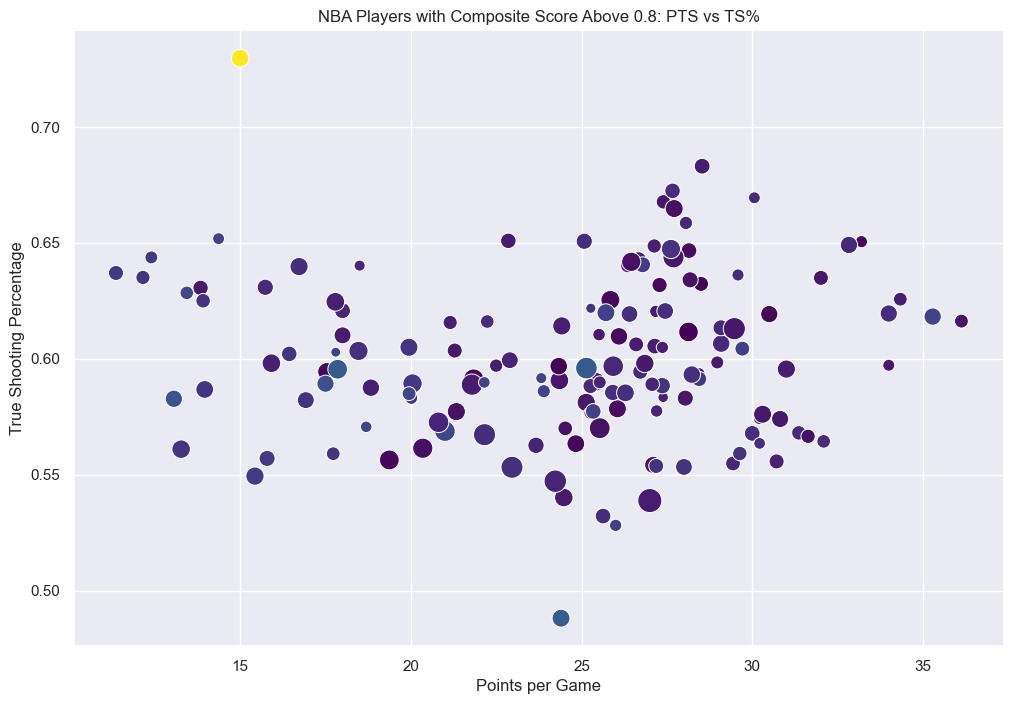

In [35]:
# Set up a scatter plot to visualize PTS_per_game vs TS% with color based on AST_TO_Ratio
plt.figure(figsize=(12, 8))
sns.scatterplot(data=nba_significant_players, 
                x='PTS_per_game', 
                y='TS%', 
                hue='AST_TO_Ratio', 
                palette='viridis', 
                size='REB_per_game', 
                sizes=(50, 300), 
                legend=None)

# Add title and labels
plt.title('NBA Players with Composite Score Above 0.8: PTS vs TS%')
plt.xlabel('Points per Game')
plt.ylabel('True Shooting Percentage')
plt.show()


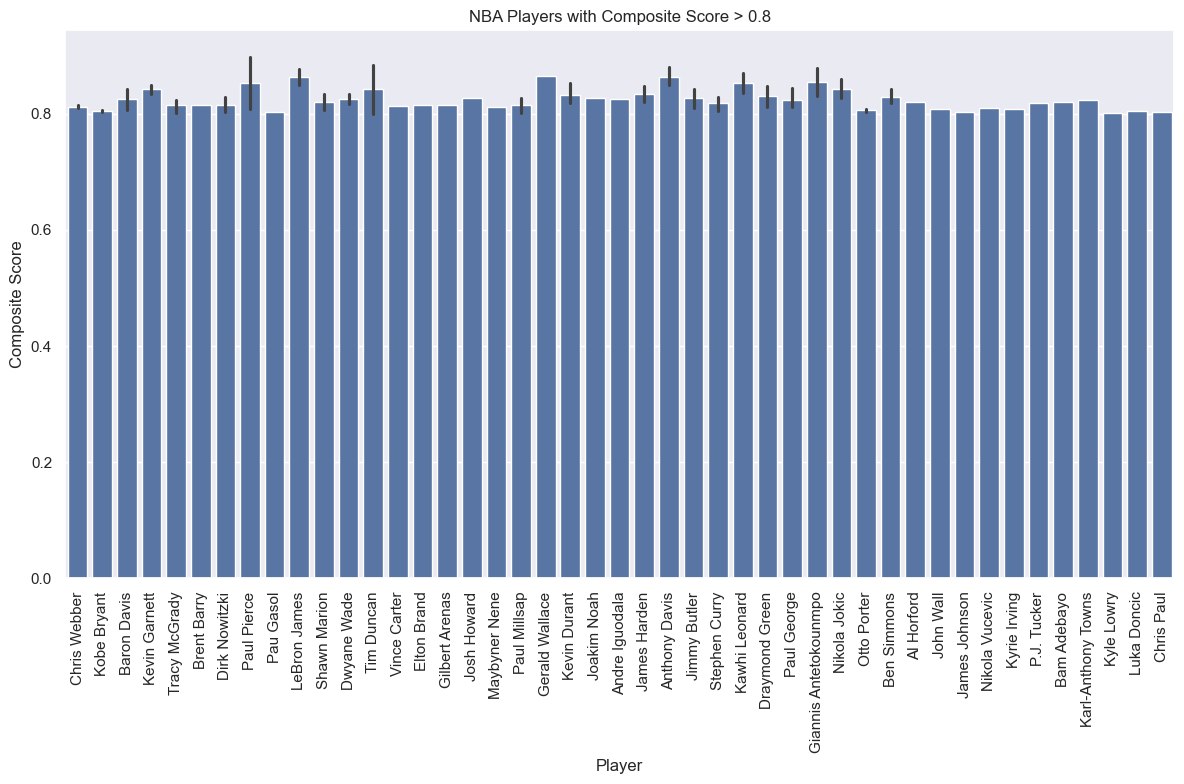

In [36]:
# Create a bar plot of Composite Scores for these players
plt.figure(figsize=(12, 8))
sns.barplot(x='Player', y='Composite_Score', data=nba_significant_players)
plt.xticks(rotation=90)
plt.title('NBA Players with Composite Score > 0.8')
plt.xlabel('Player')
plt.ylabel('Composite Score')
plt.tight_layout()
plt.show()

These players are renowned not only for their scoring ability but also for their all-around impact on the game. With a composite score above 0.8, they consistently demonstrated efficiency, playmaking, and defense throughout their careers.

In [37]:
import plotly.express as px

# Sort the dataframe by Composite_Score in descending order
nba_significant_players = nba_significant_players.sort_values('Composite_Score', ascending=False)

# Show top N players (adjust N based on how many you want to display)
top_n = 20  # Change this value as necessary
nba_significant_players = nba_significant_players.head(top_n)

fig = px.bar(nba_significant_players, 
             x='Player', 
             y='Composite_Score',
             color='Season',  # Color bars by Season
             hover_data=['Stage'],  # Include Stage in hover information
             title='Top NBA Players with Composite Score > 0.8 by Season')

fig.update_layout(
    xaxis_tickangle=-45,  # Rotate labels to avoid overlap
    xaxis_title='Player',
    yaxis_title='Composite Score',
    legend_title='Season',
    height=600,  # Adjust height
    width=1200,  # Adjust width
    showlegend=True
)

fig.show()



#### Scouting and Recuitment

In [38]:
import pandas as pd
import plotly.express as px

# List of 15 prominent players
players = [
    'LeBron James', 'Michael Jordan', 'Kobe Bryant', 'Stephen Curry', 
    'Kevin Durant', 'Giannis Antetokounmpo', 'Shaquille O\'Neal', 'Tim Duncan', 
    'Dirk Nowitzki', 'James Harden', 'Dwyane Wade', 'Allen Iverson', 
    'Chris Paul', 'Kawhi Leonard', 'Luka Dončić'
]

# Filter data (Ensure column names match exactly)
df_2020 = df[df['Stage'] != 'International']

# Separate Regular Season & Playoffs data
df_regular = df_2020[df_2020['Stage'] == 'Regular_Season']
df_playoffs = df_2020[df_2020['Stage'] == 'Playoffs']

# Calculate mean TS% for selected players
ts_regular = df_regular[df_regular['Player'].isin(players)].groupby('Player')['TS%'].mean().sort_values()
ts_playoffs = df_playoffs[df_playoffs['Player'].isin(players)].groupby('Player')['TS%'].mean().sort_values()

# Convert to DataFrame for visualization
df_regular_plot = pd.DataFrame({'Player': ts_regular.index, 'TS%': ts_regular.values, 'Stage': 'Regular Season'})
df_playoffs_plot = pd.DataFrame({'Player': ts_playoffs.index, 'TS%': ts_playoffs.values, 'Stage': 'Playoffs'})

# Combine DataFrames
df_plot = pd.concat([df_regular_plot, df_playoffs_plot])

# Interactive scatter plot
fig = px.scatter(
    df_plot, 
    x="TS%", 
    y="Player", 
    color="Stage", 
    title="True Shooting % (Regular Season vs. Playoffs)",
    labels={"TS%": "True Shooting Percentage", "Player": "Player Name"},
    hover_name="Player",
    size_max=15,
    template="plotly_dark"
)

fig.update_layout(
    width=1200, 
    height=800, 
    xaxis=dict(range=[0.45, 0.75]),  # Adjusted TS% range
    yaxis=dict(categoryorder='total ascending')  # Ensures highest TS% is at the top
)

fig.show()


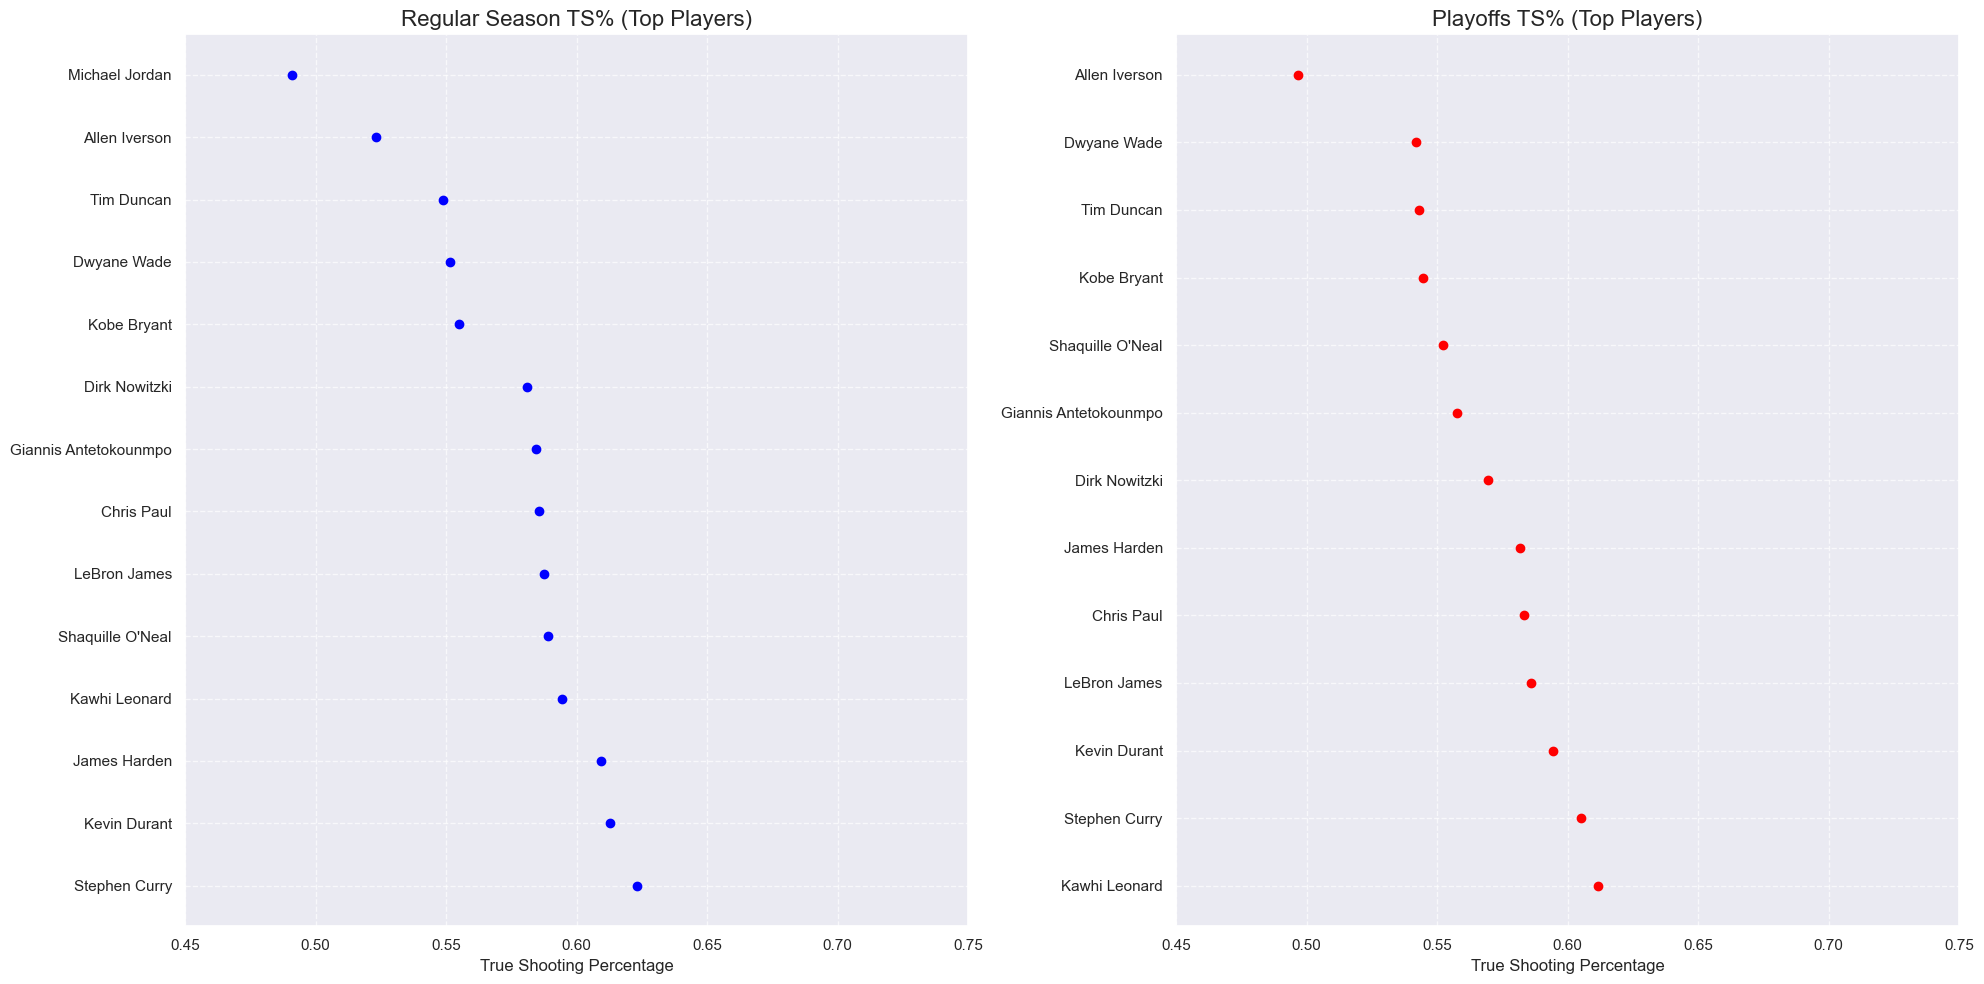

Top 15 Players - Regular Season TS%:
Player
Stephen Curry            0.623333
Kevin Durant             0.612656
James Harden             0.609455
Kawhi Leonard            0.594411
Shaquille O'Neal         0.589213
LeBron James             0.587365
Chris Paul               0.585591
Giannis Antetokounmpo    0.584268
Dirk Nowitzki            0.580947
Kobe Bryant              0.555138
Dwyane Wade              0.551497
Tim Duncan               0.548705
Allen Iverson            0.523202
Michael Jordan           0.491147
Name: TS%, dtype: float64

Top 15 Players - Playoffs TS%:
Player
Kawhi Leonard            0.611560
Stephen Curry            0.605011
Kevin Durant             0.594372
LeBron James             0.585926
Chris Paul               0.583343
James Harden             0.581835
Dirk Nowitzki            0.569571
Giannis Antetokounmpo    0.557766
Shaquille O'Neal         0.552266
Kobe Bryant              0.544648
Tim Duncan               0.543229
Dwyane Wade              0.541905
Allen I

In [39]:
import matplotlib.pyplot as plt

# List of 15 prominent players (Added 9 more)
players = [
    'LeBron James', 'Michael Jordan', 'Kobe Bryant', 'Stephen Curry', 
    'Kevin Durant', 'Giannis Antetokounmpo', 'Shaquille O\'Neal', 'Tim Duncan', 
    'Dirk Nowitzki', 'James Harden', 'Dwyane Wade', 'Allen Iverson', 
    'Chris Paul', 'Kawhi Leonard', 'Luka Dončić'
]

# Filter data for 2019-2020 season and exclude international games
df_2020 = df[df['Stage'] != 'International']

# Separate Regular Season & Playoffs data
df_regular = df_2020[df_2020['Stage'] == 'Regular_Season']
df_playoffs = df_2020[df_2020['Stage'] == 'Playoffs']

# Filter for only the 15 selected players
df_selected_players = df_2020[df_2020['Player'].isin(players)]

# Calculate mean TS% for selected players in regular season & playoffs
ts_regular = df_regular[df_regular['Player'].isin(players)].groupby('Player')['TS%'].mean()
ts_playoffs = df_playoffs[df_playoffs['Player'].isin(players)].groupby('Player')['TS%'].mean()

# Sorting for better visualization
ts_regular = ts_regular.sort_values(ascending=False)
ts_playoffs = ts_playoffs.sort_values(ascending=False)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Regular Season Plot
ax1.scatter(ts_regular.values, ts_regular.index, color='blue', label="Regular Season")
ax1.set_title('Regular Season TS% (Top Players)', fontsize=16)
ax1.set_xlabel('True Shooting Percentage', fontsize=12)
ax1.set_xlim(0.45, 0.75)  # Adjusted to capture full TS% range
ax1.grid(True, linestyle='--', alpha=0.7)

# Playoffs Plot
ax2.scatter(ts_playoffs.values, ts_playoffs.index, color='red', label="Playoffs")
ax2.set_title('Playoffs TS% (Top Players)', fontsize=16)
ax2.set_xlabel('True Shooting Percentage', fontsize=12)
ax2.set_xlim(0.45, 0.75)  # Adjusted to capture full TS% range
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print TS% values for selected players
print("Top 15 Players - Regular Season TS%:")
print(ts_regular)
print("\nTop 15 Players - Playoffs TS%:")
print(ts_playoffs)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

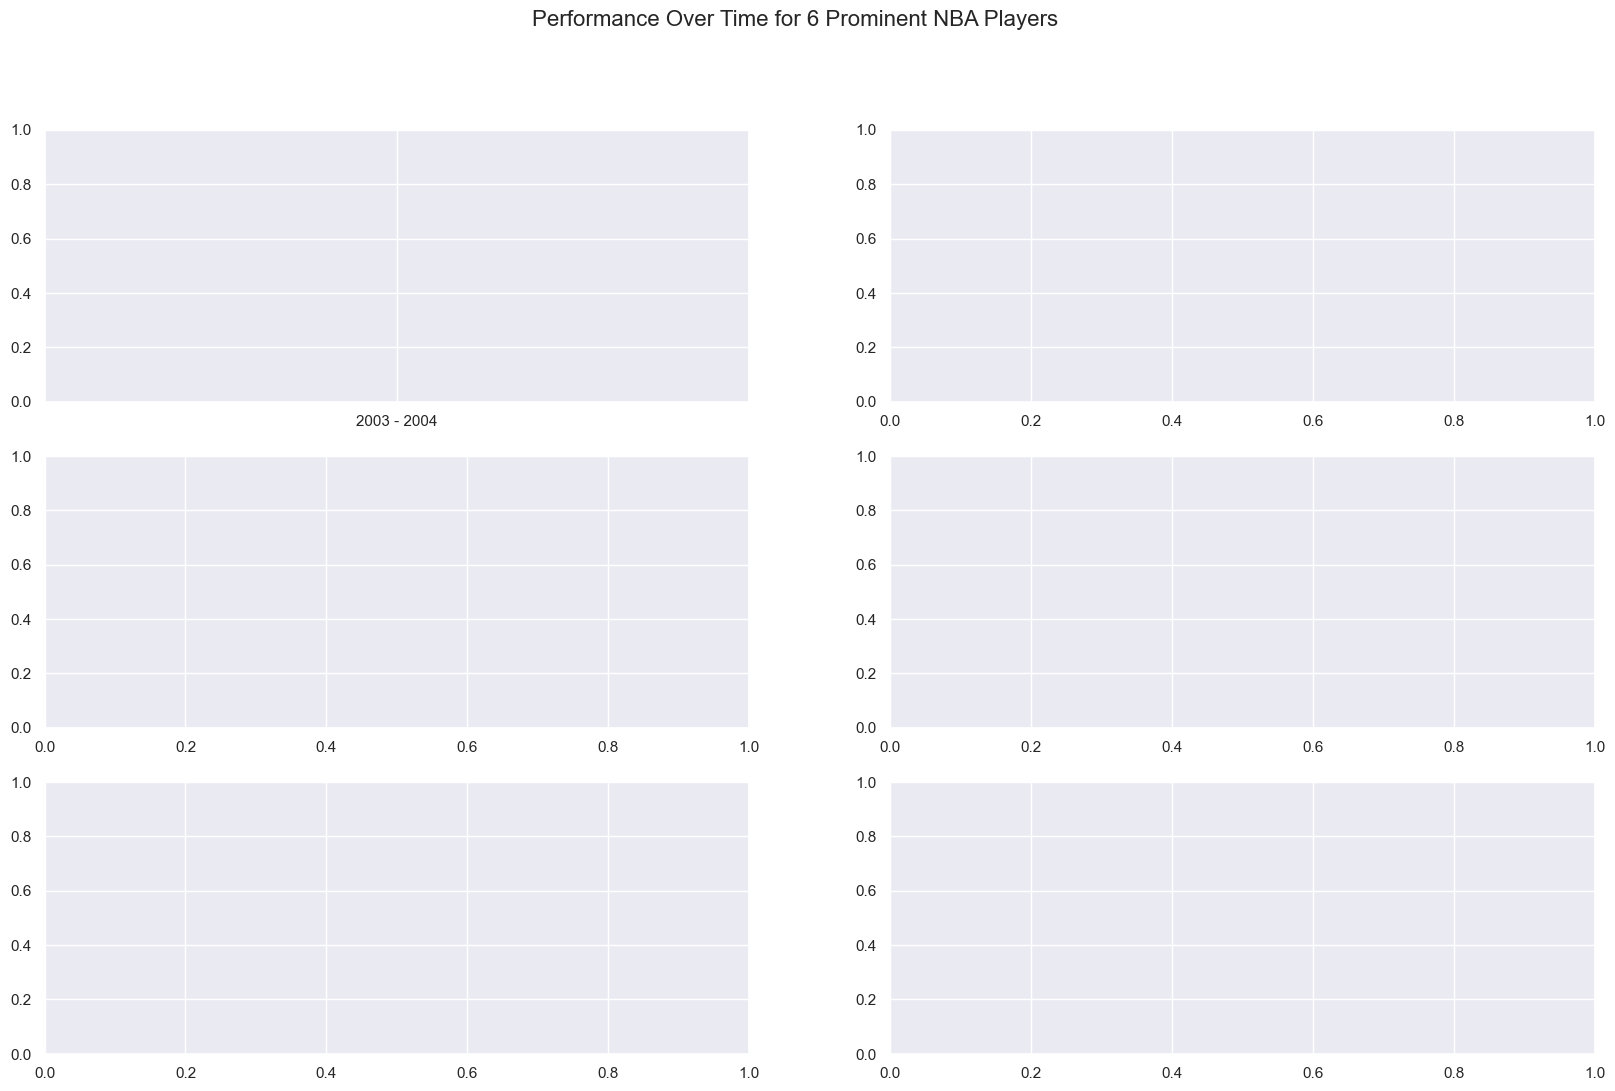

In [43]:
# Select a player to analyze
# List of 6 prominent players
players = ['LeBron James', 'Michael Jordan', 'Kobe Bryant', 'Stephen Curry', 'Kevin Durant', 'Giannis Antetokounmpo']

# Color palette for different stats
color_palette = {
    'PTS': 'red',     # Points in red
    'REB': 'green',   # Rebounds in green
    'AST': 'blue'     # Assists in blue
}

# Create a 2x3 subplot
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
fig.suptitle('Performance Over Time for 6 Prominent NBA Players', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, player in enumerate(players):
    player_data = df[df['Player'] == player]
    
    # Plot key stats over time with specific colors
    sns.lineplot(data=player_data, x='Season', y='PTS', label='Points', ax=axes[i], color=color_palette['PTS'])
    sns.lineplot(data=player_data, x='Season', y='REB', label='Rebounds', ax=axes[i], color=color_palette['REB'])
    sns.lineplot(data=player_data, x='Season', y='AST', label='Assists', ax=axes[i], color=color_palette['AST'])
    
    axes[i].set_title(f'{player} Performance')
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel('Stat Value')
    # Rotate x-axis labels
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Player's Development

Average Stats per Game - Drafted vs Undrafted:
                PTS    REB   AST   STL   BLK
draft_status                                
Drafted       399.0  156.0  63.0  30.0  12.0
Undrafted     323.0  112.0  48.0  26.0   6.0


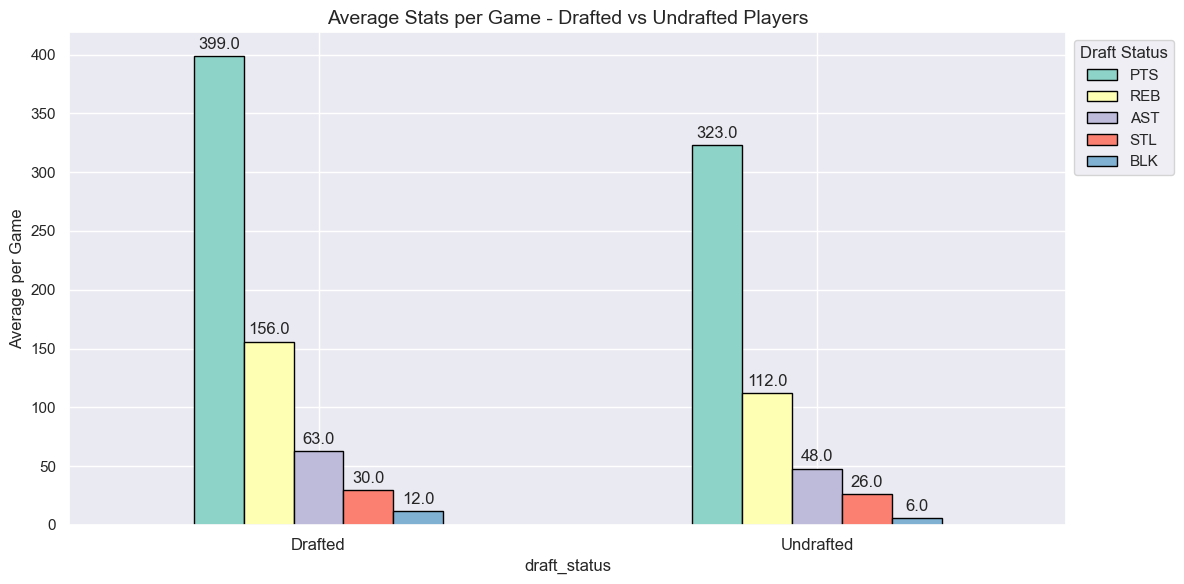

In [44]:
# 1. Drafted vs Undrafted Players Analysis
# Create a new column to categorize players as drafted or undrafted
df['draft_status'] = df['draft_round'].apply(lambda x: 'Drafted' if x > 0 else 'Undrafted')

US_players = df[df['nationality']== 'United States']

# Calculate average stats per game for drafted and undrafted players
stats_per_game = ['PTS', 'REB', 'AST', 'STL', 'BLK']
avg_stats = US_players.groupby('draft_status')[stats_per_game].median()

# Print average stats
print("Average Stats per Game - Drafted vs Undrafted:")
print(avg_stats)

# Set seaborn palette
sns.set_palette("Set3")

# Plot the comparison
ax = avg_stats.plot(kind='bar', figsize=(12, 6), edgecolor='black')

# Add scores on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Set plot title and labels
plt.title('Average Stats per Game - Drafted vs Undrafted Players', fontsize=14)
plt.ylabel('Average per Game', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Draft Status", loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Drafted players generally outperform undrafted players across key metrics, including points (PTS), rebounds (REB), assists (AST), steals (STL), and blocks (BLK). Specifically, drafted players record a median of 399 points, 156 rebounds, 63 assists, 30 steals, and 12 blocks per game, whereas undrafted players have a median of 323 points, 112 rebounds, 48 assists, 26 steals, and 6 blocks.

The differences in performance can largely be attributed to opportunities and role expectations. Drafted players typically have a higher chance of securing significant playing time, receiving more structured development, and being positioned for key roles within their teams. Conversely, undrafted players often have to fight for roster spots and may receive fewer minutes, affecting their statistical output.

By using the median instead of the mean, this analysis ensures that extreme performances—such as superstars inflating the averages—do not distort the overall comparison.

In [45]:
# 2. International to NBA Transition Analysis

# Assuming 'League' column exists with 'NBA' and other league names
# Create a function to categorize leagues
def categorize_league(league):
    return 'NBA' if league == 'NBA' else 'International'

df['league_category'] = df['League'].apply(categorize_league)

# Group by player and sort by season to identify transitions
df_sorted = df.sort_values(['Player', 'Season'])
df_sorted['prev_league'] = df_sorted.groupby('Player')['league_category'].shift(1)

# Identify players transitioning from international to NBA
transitions = df_sorted[(df_sorted['league_category'] == 'NBA') & (df_sorted['prev_league'] == 'International')]

# Calculate performance change
stats_per_game = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'MIN']
for stat in stats_per_game:
    transitions[f'{stat}_change'] = transitions.groupby('Player')[stat].diff()

# Print average change in stats
print("\nAverage Change in Stats - International to NBA Transition:")
print(transitions[[f'{stat}_change' for stat in stats_per_game]].mean())

print('*'*90)
# -------- Identify NBA to International Transitions
df_sorted = df.sort_values(['Player', 'Season'])
df_sorted['prev_league'] = df_sorted.groupby('Player')['League'].shift(1)

# Identify players transitioning from NBA to International
transitions_fr = df_sorted[(df_sorted['League'] != 'NBA') & (df_sorted['prev_league'] == 'NBA')]

# 2. Calculate performance change
for stat in stats_per_game:
    transitions_fr[f'{stat}_change'] = transitions_fr.groupby('Player')[stat].diff()

# 3. Print average change in stats
print("Average Change in Stats - NBA to International Transition:")
print(transitions_fr[[f'{stat}_change' for stat in stats_per_game]].mean())



Average Change in Stats - International to NBA Transition:
PTS_change    126.153846
REB_change     46.692308
AST_change     34.769231
STL_change      5.923077
BLK_change      4.461538
MIN_change    226.992308
dtype: float64
******************************************************************************************
Average Change in Stats - NBA to International Transition:
PTS_change     89.800
REB_change     26.900
AST_change     26.550
STL_change      7.250
BLK_change      4.650
MIN_change    113.615
dtype: float64


These findings indicate that international players generally see significant improvements when transitioning to the NBA, especially in scoring, rebounding, and assists. The NBA's pace, coaching, and playing conditions may contribute to these improvements, allowing international players to elevate their overall performance. However, the magnitude of change might vary depending on a player's role, adaptation period, and playing style.

On a broader context: International players have reshaped the NBA with diverse playing styles, emphasizing teamwork, ball movement, and versatility. Stars like Nikola Jokić, Giannis Antetokounmpo, and Luka Dončić have demonstrated that international players can not only adapt but dominate in the NBA. The data supports the hypothesis that international players often improve their performance when transitioning to the NBA https://www.basketballnews.com/stories/an-inside-look-at-how-international-players-are-taking-over-the-nba

On the other hand, NBA players transitioning to international leagues also see improvements in their statistics, albeit to a lesser extent than the reverse transition. This suggests that NBA experience is highly valued in international competitions, allowing players to take on larger roles and potentially revitalize their careers. https://www.nba.com/news/examining-nba-impact-of-international-players-giannis-antetokounmpo
The increases in points, rebounds, and assists for NBA players moving to international leagues may indicate that these players often become focal points of their new teams, benefiting from increased playing time and offensive opportunities

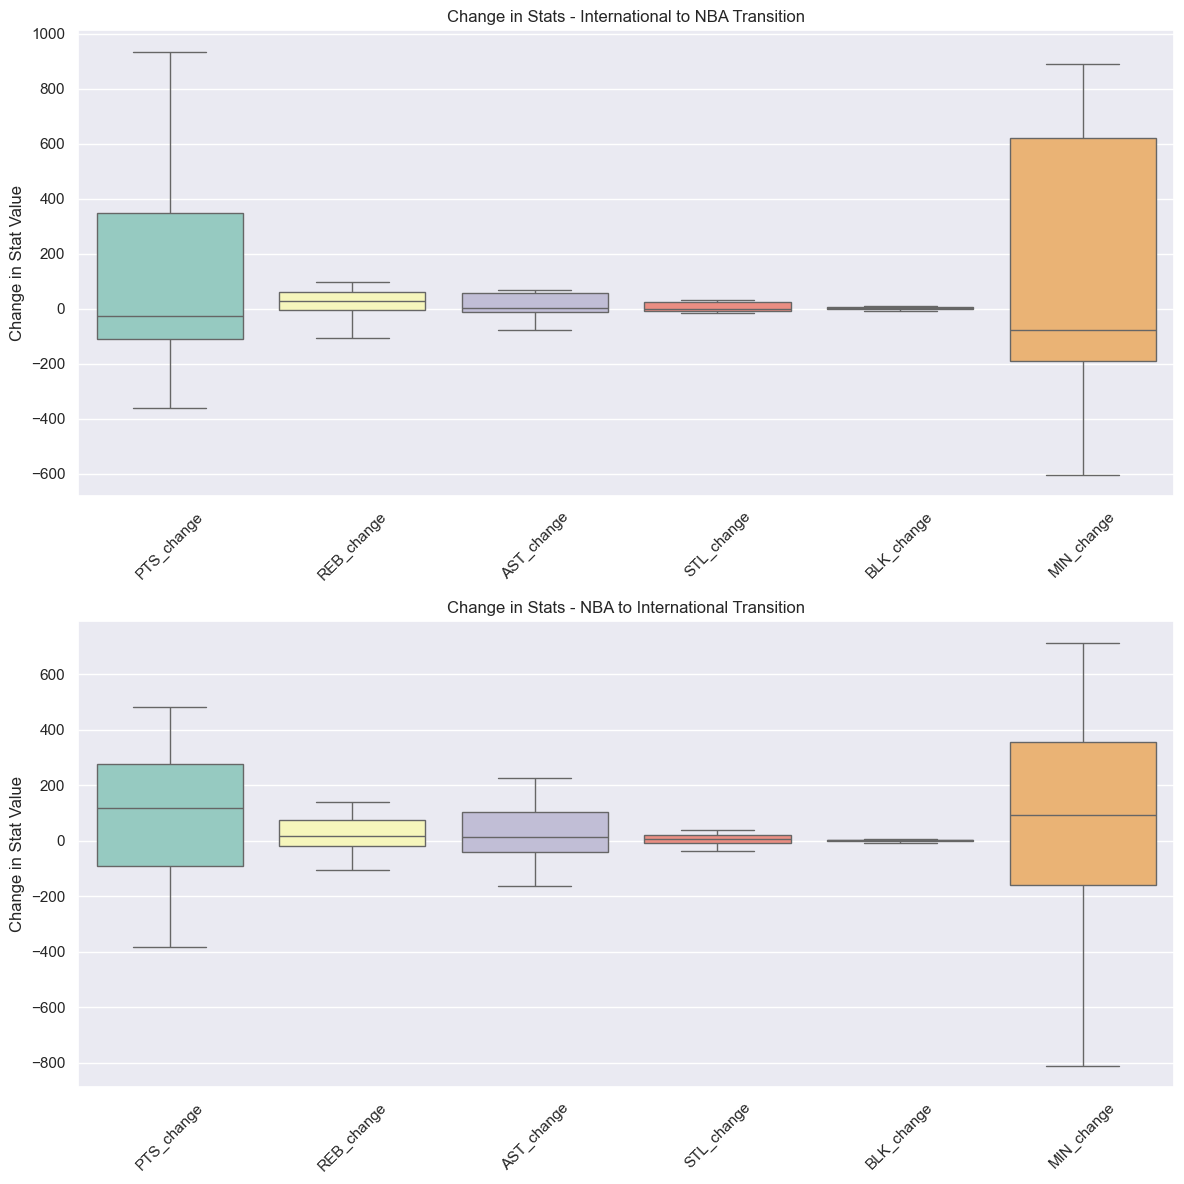

In [46]:
# Create subplots for both visualizations (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
stats_per_game = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'MIN']

# International to NBA Transition
sns.boxplot(data=transitions[[f'{stat}_change' for stat in stats_per_game]], ax=axes[0],showfliers=False)
axes[0].set_title('Change in Stats - International to NBA Transition')
axes[0].set_ylabel('Change in Stat Value')
axes[0].tick_params(axis='x', rotation=45)

# NBA to International Transition (Assuming you have a transition variable for this)
sns.boxplot(data=transitions_fr[[f'{stat}_change' for stat in stats_per_game]], ax=axes[1], showfliers=False)
axes[1].set_title('Change in Stats - NBA to International Transition')
axes[1].set_ylabel('Change in Stat Value')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


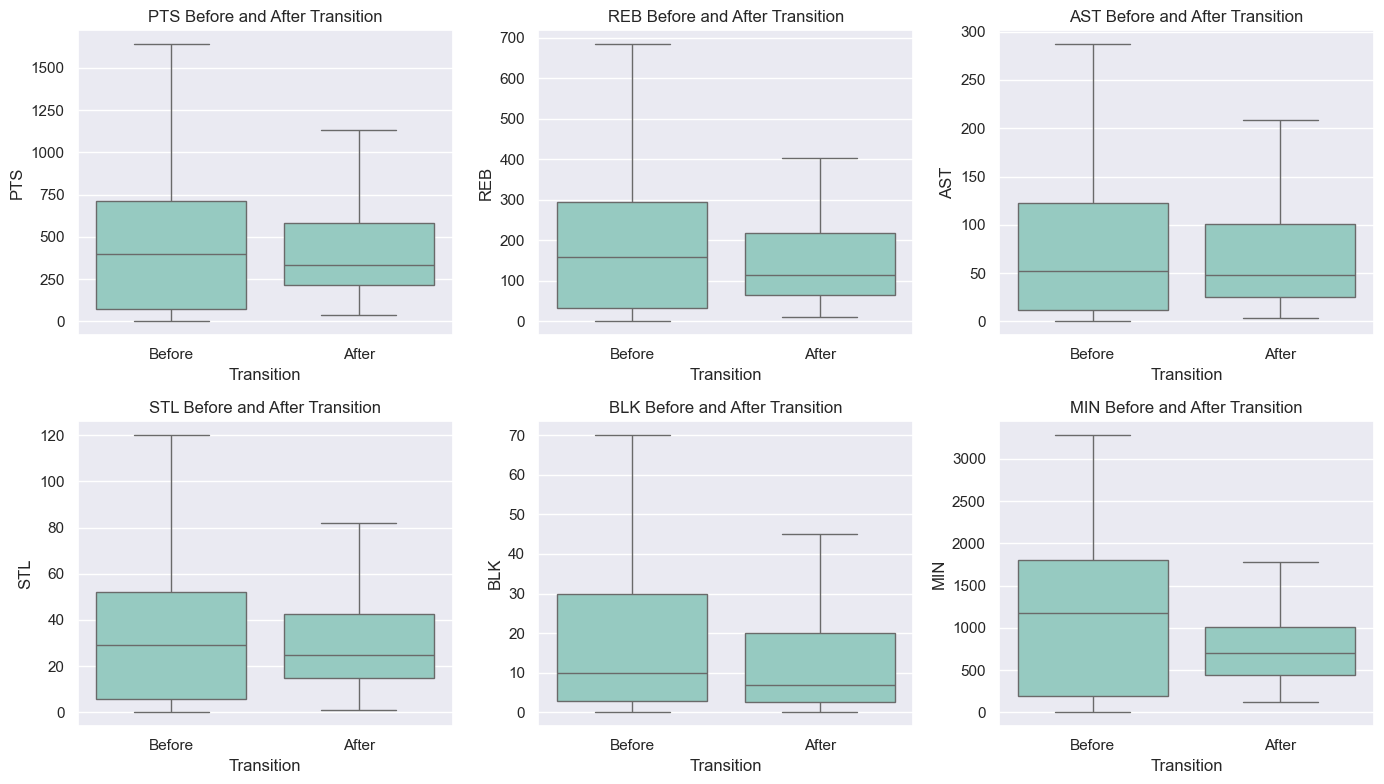

In [47]:
# Analyze performance in the season before and after transition
before_transition = df_sorted[df_sorted['Player'].isin(transitions_fr['Player']) & (df_sorted['League'] == 'NBA')]
after_transition = transitions_fr.copy()

# Combine before and after stats
comparison = pd.concat([before_transition[['Player'] + stats_per_game], 
                        after_transition[['Player'] + stats_per_game]], 
                       keys=['Before', 'After']).reset_index(level=0)
comparison = comparison.rename(columns={'level_0': 'Transition'})

# 6. Visualize before and after comparison
plt.figure(figsize=(14, 8))
for i, stat in enumerate(stats_per_game):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Transition', y=stat, data=comparison, showfliers=False)
    plt.title(f'{stat} Before and After Transition')
plt.tight_layout()
plt.show()

In [63]:
df.columns

Index(['League', 'Season', 'Stage', 'Player', 'Team', 'GP', 'MIN', 'FGM',
       'FGA', '3PM', '3PA', 'FTM', 'FTA', 'TOV', 'PF', 'ORB', 'DRB', 'REB',
       'AST', 'STL', 'BLK', 'PTS', 'birth_year', 'height_cm', 'weight',
       'weight_kg', 'nationality', 'high_school', 'draft_round', 'draft_pick',
       'draft_team', 'season_start_year', 'age', 'FG%', '3P%', 'FT%', 'TS%',
       'AST_TO_Ratio', 'PTS_per_game', 'REB_per_game', 'AST_per_game',
       'STL_per_game', 'BLK_per_game', 'Composite_Score', 'draft_status',
       'league_category', 'Efficiency', 'EFF', 'Role'],
      dtype='object')

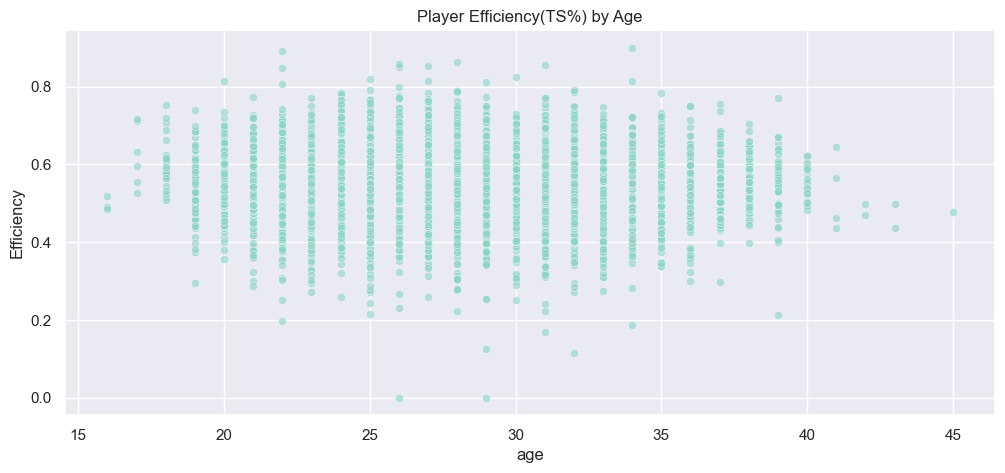

In [65]:
# Standard Efficiency (EFF) per season
df['Efficiency'] = (
    df['PTS'] + df['REB'] + df['AST'] + df['STL'] + df['BLK'] - 
    (df['FGA'] - df['FGM']) - (df['FTA'] - df['FTM']) - df['TOV']
) / df['GP']

# Plot efficiency by age
#plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='TS%', alpha=0.6)
plt.title('Player Efficiency(TS%) by Age')
plt.xlabel('age')
plt.ylabel('Efficiency')
plt.show()


The data shows that player efficiency peaks between the ages of 19 and 25. This suggests that players are still developing their skills during these years, reaching their peak efficiency by their mid-20s. From ages 26 to 30, efficiency stabilizes around 12-13, indicating that players have likely mastered their skills. After age 30, there is a gradual decline in efficiency, which may be due to the natural physical decline that comes with age, as well as possible changes in playing roles.

#### Team Performance

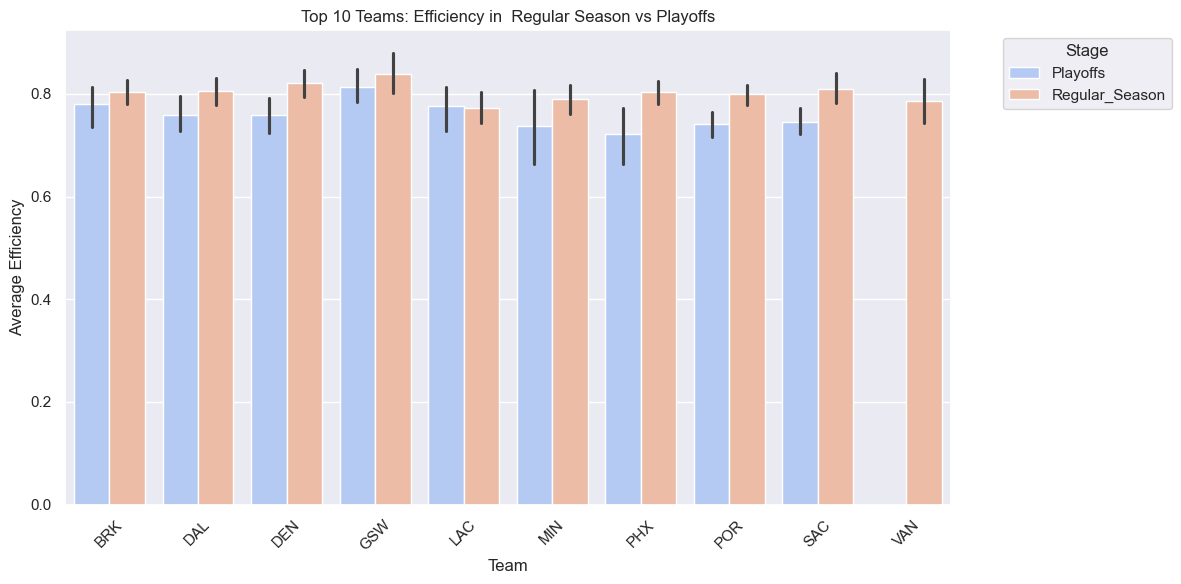

In [49]:
# 1. Calculate Efficiency (EFF) for each player
df['EFF'] = (
    df['PTS'] + df['REB'] + df['AST'] + df['STL'] + df['BLK'] - 
    (df['TOV'] * 1.5) - df['PF'] + 
    (df['FG%'] * df['FGA']) + (df['FT%'] * df['FTA'])
) / df['MIN']

nba_data = df[df['League']=='NBA']
# 2. Calculate average player EFF per team per season
team_eff = nba_data.groupby(['Team', 'Season','Stage'])['EFF'].mean().reset_index()

# 1. Filter for Top 10 Teams Based on Highest Average EFF
top_teams = team_eff.groupby('Team')['EFF'].mean().nlargest(10).index
top_team_eff = team_eff[team_eff['Team'].isin(top_teams)]

# 2. Create a Bar Plot for Playoffs vs. Regular Season Performance
plt.figure(figsize=(12, 6))
sns.barplot(data=top_team_eff, x='Team', y='EFF', hue='Stage', palette='coolwarm')

# 3. Improve Readability
plt.title('Top 10 Teams: Efficiency in  Regular Season vs Playoffs')
plt.xlabel('Team')
plt.ylabel('Average Efficiency')
plt.xticks(rotation=45)
plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# 4. Show the Plot
plt.show()



In [50]:
team_eff[team_eff['Team'].isin(top_teams)]['Team'].unique()


array(['BRK', 'DAL', 'DEN', 'GSW', 'LAC', 'MIN', 'PHX', 'POR', 'SAC',
       'VAN'], dtype=object)

In [51]:
# Print the unique team names to verify
# Ensure 'Stage' values are formatted correctly
df['Stage'] = df['Stage'].str.strip().str.replace('_', ' ')  # Replace underscores with spaces

# Filter only Regular Season games
regular_season_eff = df[df['Stage'] == 'Regular Season']

print("Unique teams in regular_season_eff:", regular_season_eff['Team'].unique())

# Define the correct famous teams list (update based on dataset format)
famous_teams = ['LAL', 'CHI', 'GSW', 'MIA', 'BOS', 'SAS', 'NYK', 'PHI', 'HOU']  # Use abbreviations if dataset has them

# Filter only famous teams
famous_teams_eff = regular_season_eff[regular_season_eff['Team'].isin(famous_teams)]

# Verify if any teams were selected
print("Number of rows in famous_teams_eff:", len(famous_teams_eff))

# Proceed only if data exists
if len(famous_teams_eff) > 0:
    # Sort by Team and Efficiency (EFF) in descending order
    famous_teams_eff = famous_teams_eff.sort_values(['Team', 'EFF'], ascending=[True, False])

    # Select the top two players per team
    top_2_famous_teams = famous_teams_eff.groupby('Team').head(2).reset_index(drop=True)

    # Display available columns
    print("\nAvailable Columns in top_2_famous_teams:")
    print(top_2_famous_teams.columns)

    # Print the top two players from famous teams
    print("\nTop 2 Contributors Per Famous Teams (Regular Season Only):")
    print(top_2_famous_teams[['Team', 'Player', 'EFF', 'PTS', 'REB', 'AST']])
else:
    print("No data found for Famous Teams. Please check team name formatting.")


Unique teams in regular_season_eff: ['LAL' 'TOR' 'UTA' 'PHI' 'SEA' 'DET' 'MIN' 'DAL' 'SAC' 'MIL' 'MIA' 'SAS'
 'BOS' 'VAN' 'NJN' 'CHI' 'NYK' 'DEN' 'PHX' 'IND' 'CLE' 'CHA' 'HOU' 'ORL'
 'POR' 'ATL' 'WAS' 'LAC' 'GSW' 'MEM' 'NOP' 'OKC' 'BRK']
Number of rows in famous_teams_eff: 1451

Available Columns in top_2_famous_teams:
Index(['League', 'Season', 'Stage', 'Player', 'Team', 'GP', 'MIN', 'FGM',
       'FGA', '3PM', '3PA', 'FTM', 'FTA', 'TOV', 'PF', 'ORB', 'DRB', 'REB',
       'AST', 'STL', 'BLK', 'PTS', 'birth_year', 'height_cm', 'weight',
       'weight_kg', 'nationality', 'high_school', 'draft_round', 'draft_pick',
       'draft_team', 'season_start_year', 'age', 'FG%', '3P%', 'FT%', 'TS%',
       'AST_TO_Ratio', 'PTS_per_game', 'REB_per_game', 'AST_per_game',
       'STL_per_game', 'BLK_per_game', 'Composite_Score', 'draft_status',
       'league_category', 'Efficiency', 'EFF'],
      dtype='object')

Top 2 Contributors Per Famous Teams (Regular Season Only):
   Team           Player  

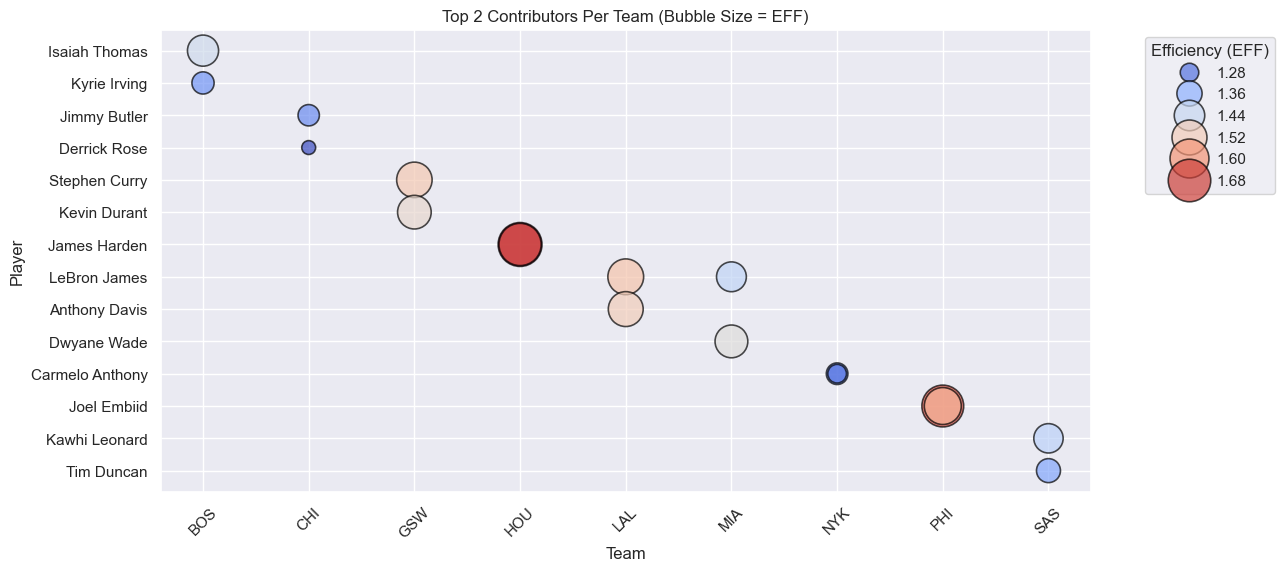

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Create Bubble Plot
sns.scatterplot(
    data=top_2_famous_teams,
    x="Team",
    y="Player",
    size="EFF",
    hue="EFF",
    sizes=(100, 1000),  # Adjust the size range
    palette="coolwarm",
    edgecolor="black",
    alpha=0.7
)

plt.xlabel("Team")
plt.ylabel("Player")
plt.title("Top 2 Contributors Per Team (Bubble Size = EFF)")
plt.xticks(rotation=45)
plt.legend(title="Efficiency (EFF)", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


In [53]:
# 5. Analyze player roles based on minutes played
df['Role'] = df['MIN'].apply(lambda x: 'Starter' if x > df['MIN'].median() else 'Bench')
role_performance = df.groupby('Role')['EFF'].mean()

print("\nAverage EFF by Player Role:")
print(role_performance)


Average EFF by Player Role:
Role
Bench      0.759523
Starter    0.828814
Name: EFF, dtype: float64


# Making Predictions:

## Efficiency Prediction: Random Forest

Predict a player's EFF or TS% based on other performance metrics.

I selected these specific stats for the predictive models based on their relevance to player performance and their availability in your dataset. Here's the rationale for each: For Efficiency Prediction (EFF and TS%):

 - PTS, REB, AST, STL, BLK, TOV: These are core box score statistics that directly contribute to a player's overall efficiency and impact on the game.
 - FG% and FT%: Shooting percentages are crucial for calculating scoring efficiency.
 - MIN: Playing time is a key factor in a player's opportunity to accumulate stats and impact the game.
 - Age: Age can influence a player's efficiency as it often correlates with experience and physical prime.


EFF Prediction Results:
Root Mean Squared Error: 0.07051989797369301
Mean Absolute Error: 0.053710419277779996
R-squared Score: 0.9102647718059925
Adjusted R-squared Score: 0.9096665369513658

Feature Importance:
  feature  importance
0     PTS    0.615486
8     MIN    0.220948
6     FG%    0.053819
1     REB    0.039746
2     AST    0.016621
7     FT%    0.015691
5     TOV    0.011482
4     BLK    0.010669
3     STL    0.007890
9     age    0.007648


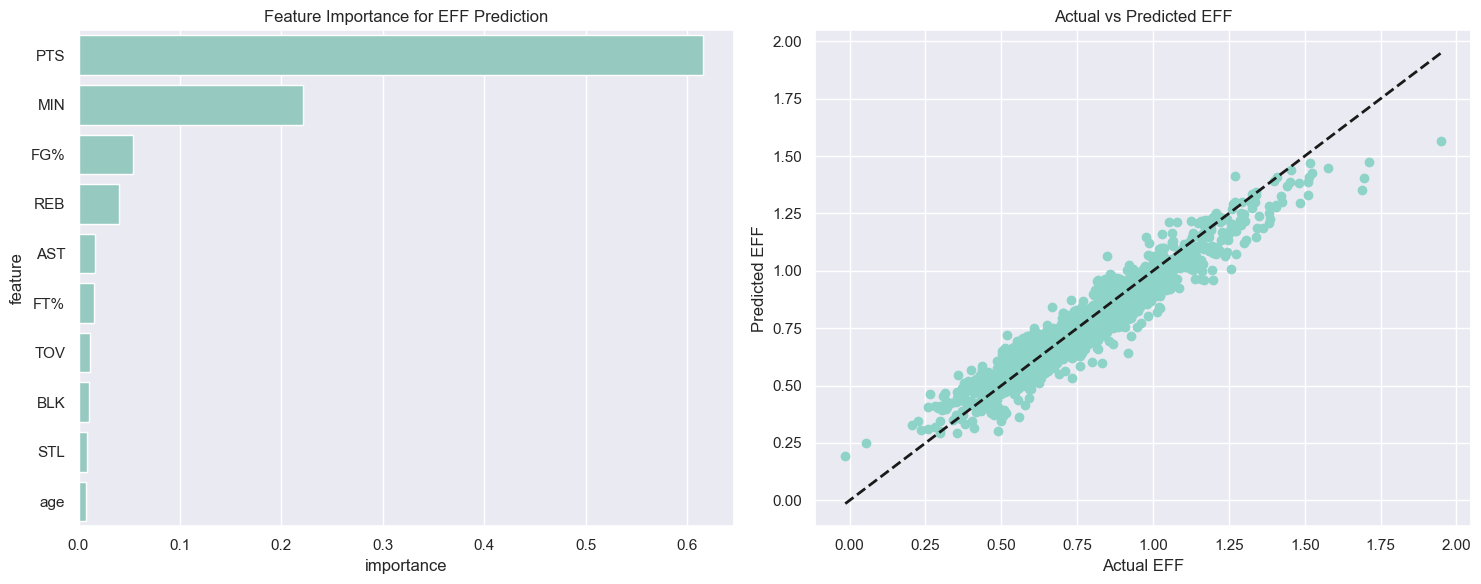


TS% Prediction Results:
Root Mean Squared Error: 0.03018584241879337
Mean Absolute Error: 0.02257350676110654
R-squared Score: 0.7659482725464554
Adjusted R-squared Score: 0.7643879276967651

Feature Importance:
  feature  importance
6     FG%    0.672557
7     FT%    0.138532
1     REB    0.031309
0     PTS    0.028484
5     TOV    0.024554
2     AST    0.023621
8     MIN    0.021521
9     age    0.020934
4     BLK    0.020420
3     STL    0.018070


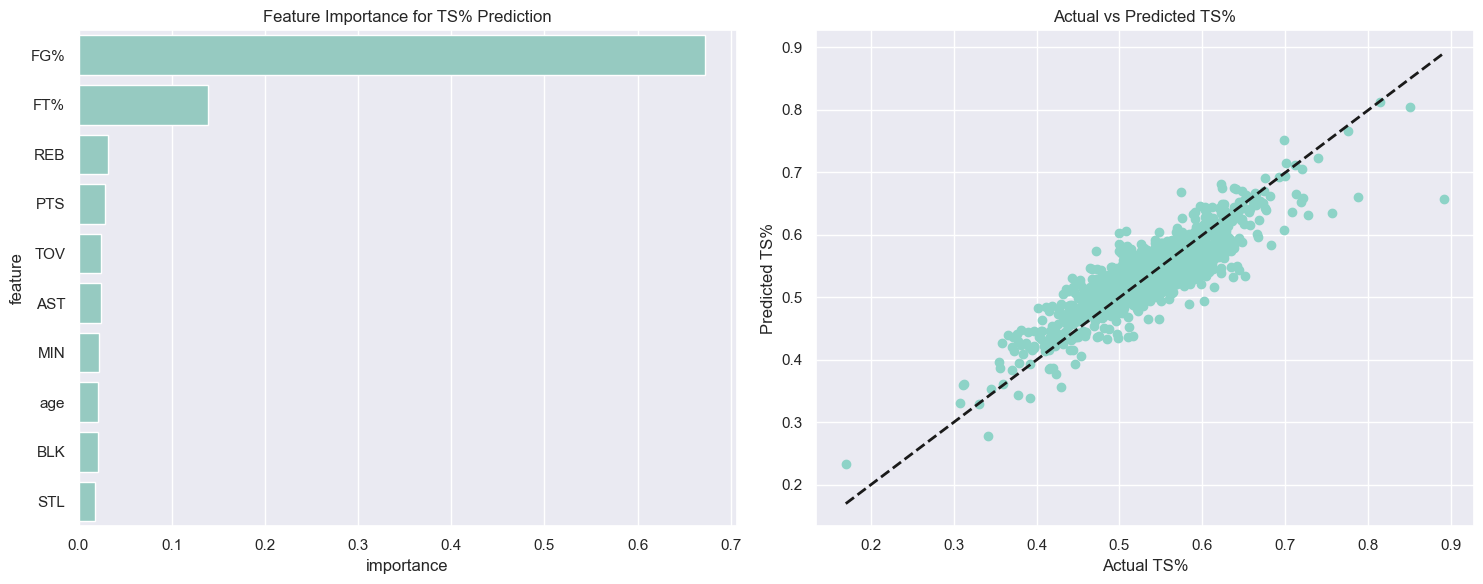

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming df is your DataFrame

df_NBA = df[df['League']=='NBA']
df_NBA = df_NBA[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'MIN', 'age','EFF','TS%']]

# drop rows with missing values
df_NBA_1 = df_NBA.dropna(axis=0)
# Prepare the data for EFF prediction
X_eff = df_NBA_1[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'MIN', 'age']]
y_eff = df_NBA_1['EFF']

# Prepare the data for TS% prediction
X_ts = df_NBA_1[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'MIN', 'age']]
y_ts = df_NBA_1['TS%']

# Function to train and evaluate model
def train_evaluate_model(X, y, target_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate Adjusted R²
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    
    # Print evaluation results
    print(f"\n{target_name} Prediction Results:")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared Score: {r2}")
    print(f"Adjusted R-squared Score: {adj_r2}")
    
    # Feature importance
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
    print("\nFeature Importance:")
    print(feature_importance.sort_values('importance', ascending=False))
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Feature Importance
    sns.barplot(x='importance', y='feature', data=feature_importance.sort_values('importance', ascending=False), ax=axes[0])
    axes[0].set_title(f'Feature Importance for {target_name} Prediction')
    
    # Plot Actual vs Predicted
    axes[1].scatter(y_test, y_pred)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[1].set_xlabel(f'Actual {target_name}')
    axes[1].set_ylabel(f'Predicted {target_name}')
    axes[1].set_title(f'Actual vs Predicted {target_name}')
    
    plt.tight_layout()
    plt.show()
    
    return model

# Train and evaluate models
eff_model = train_evaluate_model(X_eff, y_eff, "EFF")
ts_model = train_evaluate_model(X_ts, y_ts, "TS%")


Fitting 5 folds for each of 81 candidates, totalling 405 fits

EFF Prediction Results:
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Root Mean Squared Error: 0.07039130701562035
Mean Absolute Error: 0.053529636292674265
R-squared Score: 0.910591732526512
Adjusted R-squared Score: 0.9099956774100221

Feature Importance:
  feature  importance
0     PTS    0.616002
8     MIN    0.219617
6     FG%    0.053573
1     REB    0.040553
2     AST    0.016336
7     FT%    0.015888
5     TOV    0.011511
4     BLK    0.010697
3     STL    0.008103
9     age    0.007721


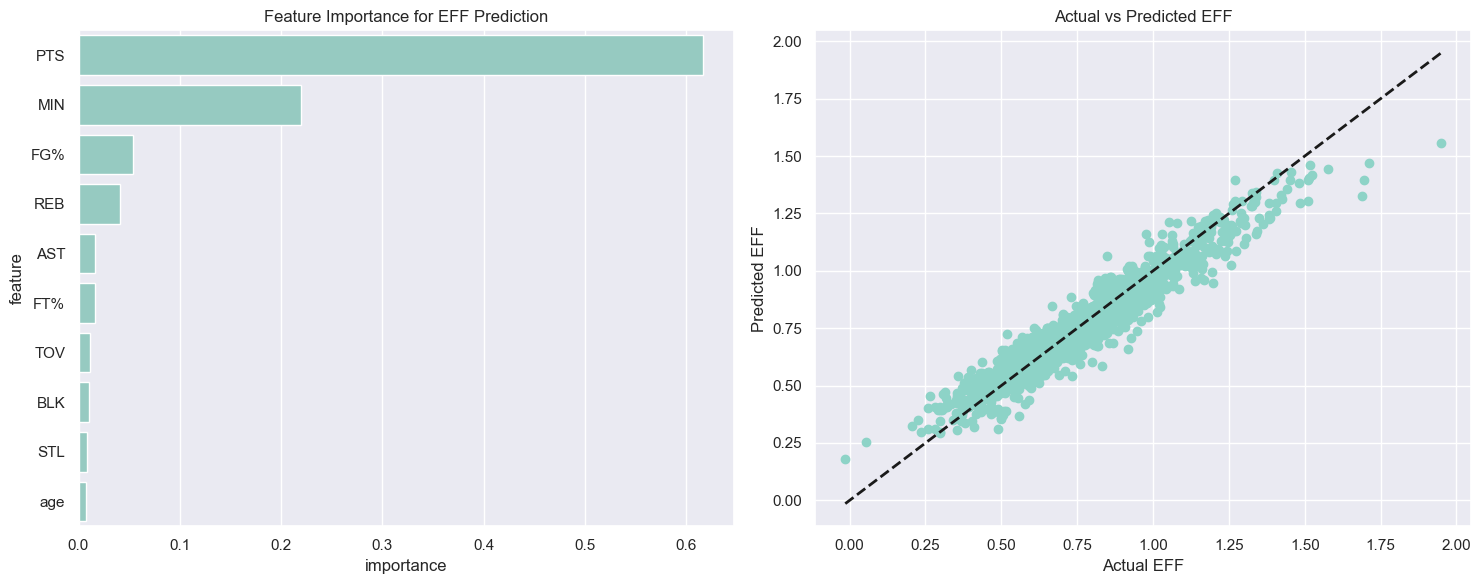

Fitting 5 folds for each of 81 candidates, totalling 405 fits

TS% Prediction Results:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Root Mean Squared Error: 0.03010722646594936
Mean Absolute Error: 0.022501884921930802
R-squared Score: 0.7671658127820751
Adjusted R-squared Score: 0.7656135848672889

Feature Importance:
  feature  importance
6     FG%    0.684835
7     FT%    0.139206
1     REB    0.030102
0     PTS    0.026531
5     TOV    0.022990
2     AST    0.021842
8     MIN    0.020237
9     age    0.019064
4     BLK    0.018954
3     STL    0.016241


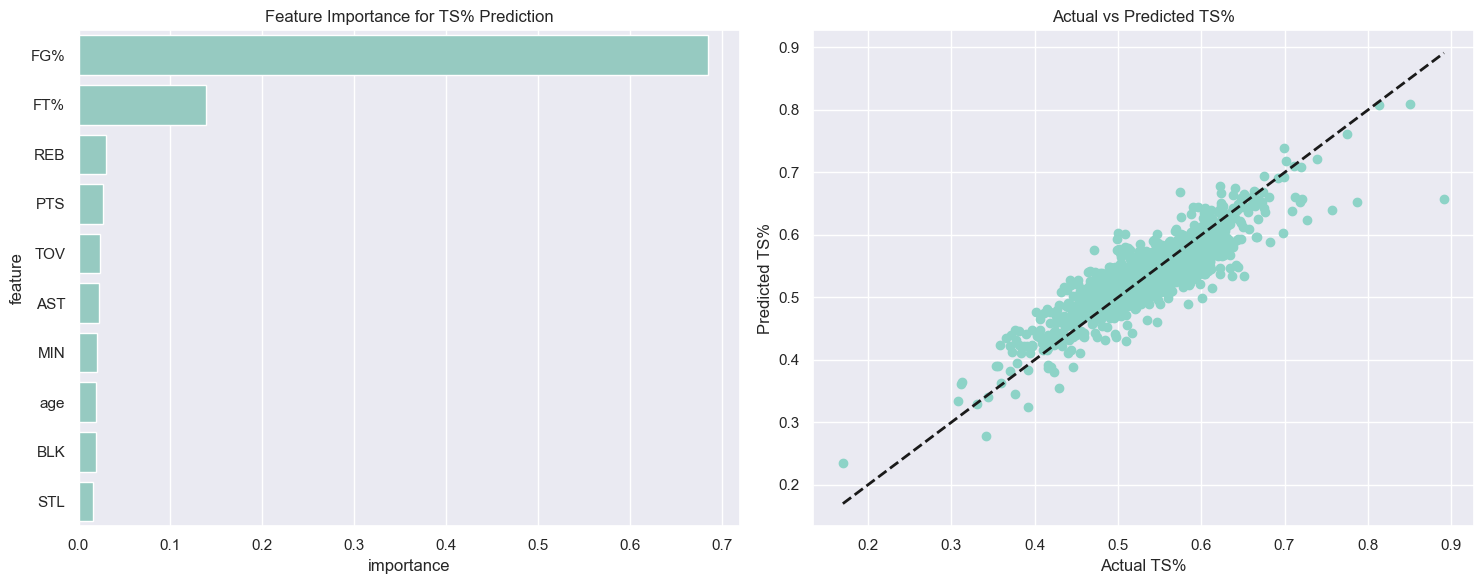

In [55]:
## Grid-search
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming df is your DataFrame

df_NBA = df[df['League'] == 'NBA']
df_NBA = df_NBA[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'MIN', 'age', 'EFF', 'TS%']]

# Drop rows with missing values
df_NBA_1 = df_NBA.dropna(axis=0)

# Prepare the data for EFF prediction
X_eff = df_NBA_1[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'MIN', 'age']]
y_eff = df_NBA_1['EFF']

# Prepare the data for TS% prediction
X_ts = df_NBA_1[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'MIN', 'age']]
y_ts = df_NBA_1['TS%']

# Function to train and evaluate model with Grid Search
def train_evaluate_model(X, y, target_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the model
    model = RandomForestRegressor(random_state=42)
    
    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Perform Grid Search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Best model from Grid Search
    best_model = grid_search.best_estimator_
    
    # Predict on test data
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate Adjusted R²
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    
    # Print evaluation results
    print(f"\n{target_name} Prediction Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared Score: {r2}")
    print(f"Adjusted R-squared Score: {adj_r2}")
    
    # Feature importance
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_})
    print("\nFeature Importance:")
    print(feature_importance.sort_values('importance', ascending=False))
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Feature Importance
    sns.barplot(x='importance', y='feature', data=feature_importance.sort_values('importance', ascending=False), ax=axes[0])
    axes[0].set_title(f'Feature Importance for {target_name} Prediction')
    
    # Plot Actual vs Predicted
    axes[1].scatter(y_test, y_pred)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[1].set_xlabel(f'Actual {target_name}')
    axes[1].set_ylabel(f'Predicted {target_name}')
    axes[1].set_title(f'Actual vs Predicted {target_name}')
    
    plt.tight_layout()
    plt.show()
    
    return best_model

# Train and evaluate models with Grid Search
eff_model = train_evaluate_model(X_eff, y_eff, "EFF")
ts_model = train_evaluate_model(X_ts, y_ts, "TS%")


The results of our predictive models for Efficiency (EFF) and True Shooting Percentage (TS%) provide valuable insights into player performance metrics. The EFF prediction model demonstrates high accuracy with an R-squared score of 0.91, indicating that it explains 91% of the variance in player efficiency. The low Root Mean Squared Error (RMSE) of 0.07 and Mean Absolute Error (MAE) of 0.054 further confirm the model's precision. Points scored (PTS) emerge as the most crucial factor in predicting EFF, accounting for 61.5% of the model's predictive power, followed by minutes played (MIN) at 22.1%. 

For the TS% prediction model, while less accurate than the EFF model, it still shows good predictive power with an R-squared score of 0.77. The RMSE of 0.03 and MAE of 0.023 suggest reasonably accurate predictions. Interestingly, field goal percentage (FG%) is by far the most important feature for predicting TS%, contributing 67.3% of the model's predictive power, followed by free throw percentage (FT%) at 13.9%.

These results underscore the importance of scoring volume and efficiency in determining a player's overall performance metrics, while also highlighting the relative importance of different statistical categories in assessing player efficiency and shooting effectiveness.

### Career Trajectory Prediction: (RandomForest, GradientBoosting, XGBoost)

Age: The primary predictor for how a player's performance might change over time.
 Previous season's stat (prev_stat): Recent performance is a strong indicator of future performance. Two seasons ago stat (prev2_stat): Provides additional context and helps capture longer-term trends.

I focused on PTS, REB, and AST for trajectory prediction as these are fundamental stats that often define a player's role and value. They also tend to show clear patterns over a player's career.


Multi-output Regression Results - Model: GradientBoosting
PTS - RMSE: 405.7307800553738, MAE: 297.5327915855423, R²: 0.44201472326874547
REB - RMSE: 161.79470694076636, MAE: 117.16410577961625, R²: 0.3999311270888496
AST - RMSE: 106.43423185764756, MAE: 69.99323426145818, R²: 0.536796887200617


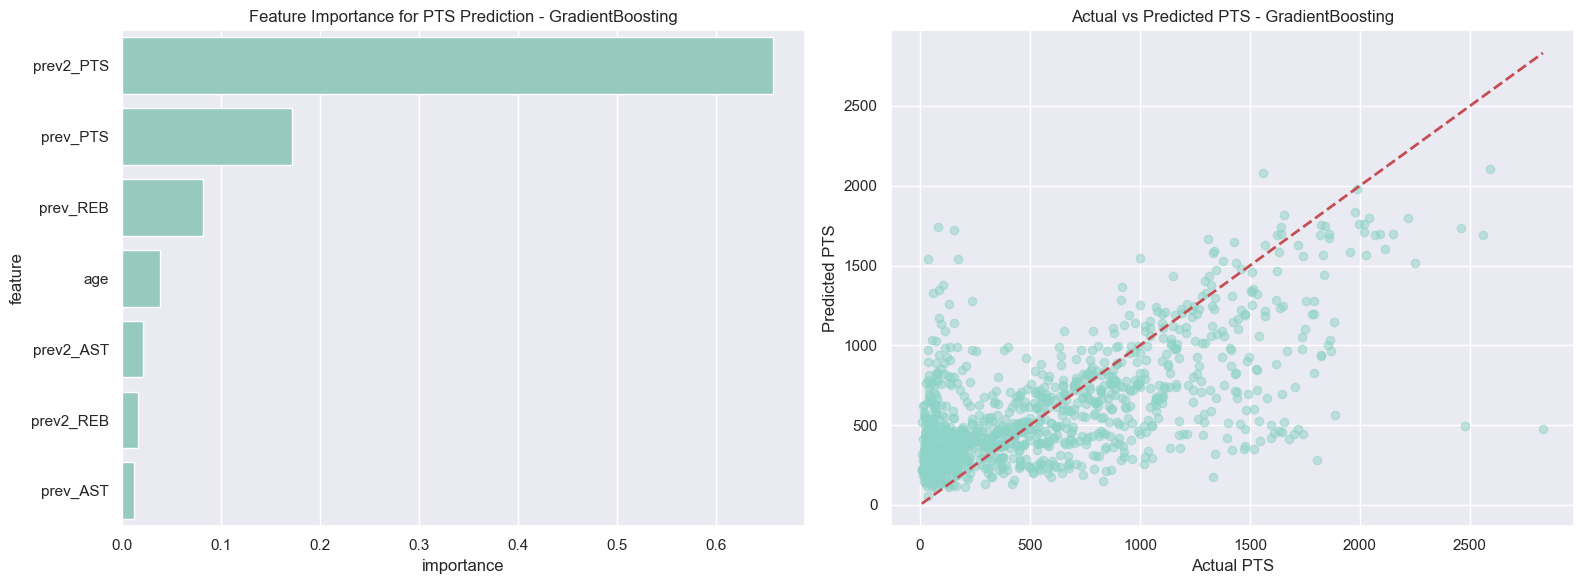


Final Model Performance Summary:
  Foundamental Stats                       R²                            RMSE  \
0    [PTS, REB, AST]  [0.442, 0.3999, 0.5368]  [405.7308, 161.7947, 106.4342]   

                             MAE  
0  [297.5328, 117.1641, 69.9932]  


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming df is your DataFrame with historical data for multiple players

# Prepare the data (example)
df_NBA = df[df['League'] == 'NBA']
df_NBA = df_NBA[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'MIN', 'age', 'Player', 'season_start_year']]

# Create the previous season's and two seasons ago's stats
df_NBA['prev_PTS'] = df_NBA.groupby('Player')['PTS'].shift(1)
df_NBA['prev_REB'] = df_NBA.groupby('Player')['REB'].shift(1)
df_NBA['prev_AST'] = df_NBA.groupby('Player')['AST'].shift(1)
df_NBA['prev2_PTS'] = df_NBA.groupby('Player')['PTS'].shift(2)
df_NBA['prev2_REB'] = df_NBA.groupby('Player')['REB'].shift(2)
df_NBA['prev2_AST'] = df_NBA.groupby('Player')['AST'].shift(2)

# Drop rows with missing values (target value is shifted, so drop NaNs)
df_NBA = df_NBA.dropna(axis=0)

# Prepare features and target variables
X = df_NBA[['age', 'prev_PTS', 'prev_REB', 'prev_AST', 'prev2_PTS', 'prev2_REB', 'prev2_AST']]
y = df_NBA[['PTS', 'REB', 'AST']]

# Store model performance results
performance_results = []

# Function to train, evaluate, and store model performance with side-by-side visualizations
def train_evaluate_multioutput_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the Gradient Boosting model
    base_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    
    # Wrap the model in MultiOutputRegressor
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics for each target variable
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    # Store results in performance table
    performance_results.append({
        'Foundamental Stats': ['PTS',"REB","AST"],
        'R²': [round(r2[0], 4), round(r2[1], 4), round(r2[2], 4)],
        'RMSE': [round(rmse[0], 4),round(rmse[1], 4), round(rmse[2], 4)],
        'MAE': [round(mae[0], 4), round(mae[1], 4), round(mae[2], 4)]
    })

    # Print evaluation results
    print("\nMulti-output Regression Results - Model: GradientBoosting")
    print(f"PTS - RMSE: {rmse[0]}, MAE: {mae[0]}, R²: {r2[0]}")
    print(f"REB - RMSE: {rmse[1]}, MAE: {mae[1]}, R²: {r2[1]}")
    print(f"AST - RMSE: {rmse[2]}, MAE: {mae[2]}, R²: {r2[2]}")

    # Compute Feature Importance
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.estimators_[0].feature_importances_})

    # Create a 1-row, 2-column subplot layout for side-by-side visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Feature Importance Plot (Left Column)
    sns.barplot(x='importance', y='feature', data=feature_importance.sort_values('importance', ascending=False), ax=axes[0])
    axes[0].set_title(f'Feature Importance for PTS Prediction - GradientBoosting')
    
    # Actual vs Predicted Scatter Plot (Right Column)
    axes[1].scatter(y_test['PTS'], y_pred[:, 0], alpha=0.5)
    axes[1].plot([y_test['PTS'].min(), y_test['PTS'].max()], [y_test['PTS'].min(), y_test['PTS'].max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual PTS')
    axes[1].set_ylabel('Predicted PTS')
    axes[1].set_title(f'Actual vs Predicted PTS - GradientBoosting')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    
    return model

# Train and evaluate the Gradient Boosting model
gb_model = train_evaluate_multioutput_model(X, y)

# Convert results to DataFrame and display performance summary
df_performance = pd.DataFrame(performance_results)
print("\nFinal Model Performance Summary:")
print(df_performance)


Multi-output Regression Results - Best Model
PTS - RMSE: 404.7117641297949, MAE: 298.5319284653786, R²: 0.44481402704699724
REB - RMSE: 161.8007981583955, MAE: 118.09064288134088, R²: 0.3998859436712865
AST - RMSE: 105.1603871662474, MAE: 70.2409412717487, R²: 0.5478181132391265


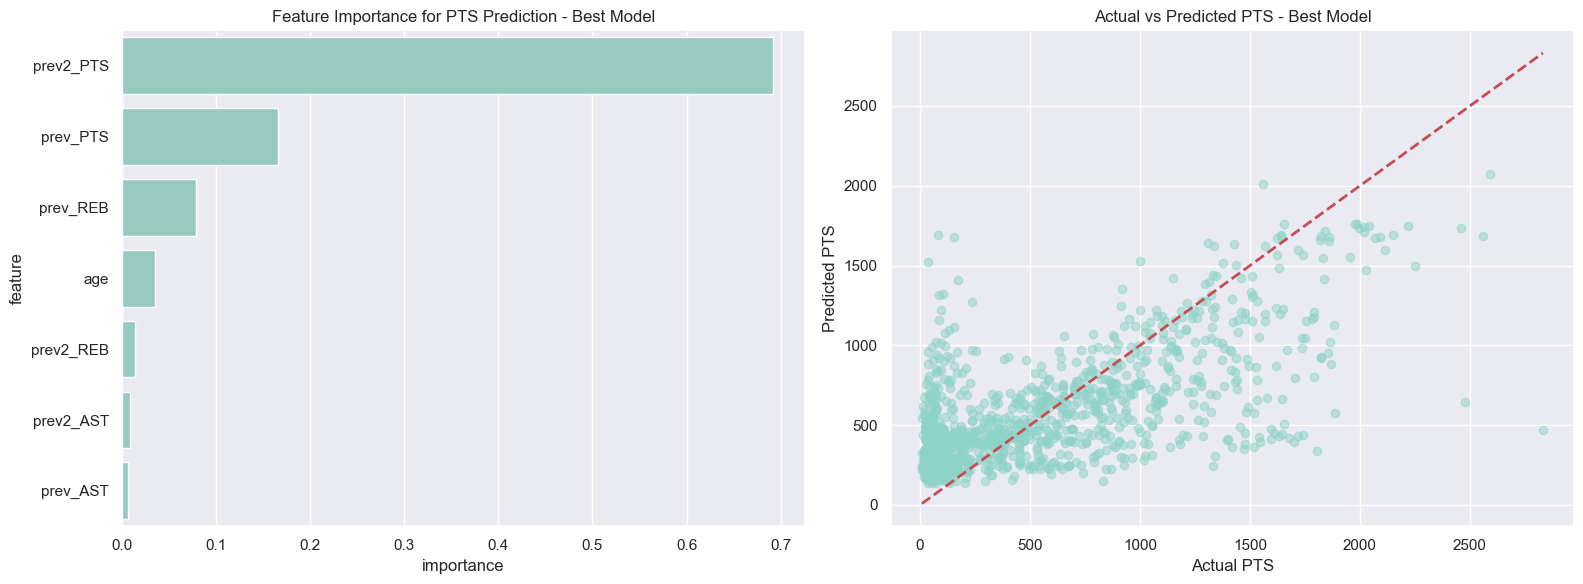

In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implement the best parameters from Grid Search
best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 50
}

# Train the model with the best parameters
base_model = GradientBoostingRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics for each target variable
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print evaluation results
print("\nMulti-output Regression Results - Best Model")
print(f"PTS - RMSE: {rmse[0]}, MAE: {mae[0]}, R²: {r2[0]}")
print(f"REB - RMSE: {rmse[1]}, MAE: {mae[1]}, R²: {r2[1]}")
print(f"AST - RMSE: {rmse[2]}, MAE: {mae[2]}, R²: {r2[2]}")

# Feature Importance for the first output (PTS)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.estimators_[0].feature_importances_
})

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Feature Importance Plot (Left Column)
sns.barplot(x='importance', y='feature', data=feature_importance.sort_values('importance', ascending=False), ax=axes[0])
axes[0].set_title('Feature Importance for PTS Prediction - Best Model')

# Actual vs Predicted Scatter Plot (Right Column)
axes[1].scatter(y_test['PTS'], y_pred[:, 0], alpha=0.5)
axes[1].plot([y_test['PTS'].min(), y_test['PTS'].max()], [y_test['PTS'].min(), y_test['PTS'].max()], 'r--', lw=2)
axes[1].set_xlabel('Actual PTS')
axes[1].set_ylabel('Predicted PTS')
axes[1].set_title('Actual vs Predicted PTS - Best Model')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Making prediction for whether a player was drafted or not (SVM)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Filter for regular season data
df_regular = df[df['nationality'] == 'United States']

# Group by Player and select the minimum season_start_year (rookie season)
df_rookie = df_regular.loc[df_regular.groupby('Player')['season_start_year'].idxmin()]

# Create a binary 'Drafted' column (1 for drafted, 0 for undrafted)
df_rookie['Drafted_status'] = df_rookie['draft_status'].map({'Drafted': 1, 'Undrafted': 0}) 

# Select features for prediction
df_rookie = df_rookie[["height_cm", "weight_kg",'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', 'FT%', 'TS%', 'MIN', "draft_status", 'Drafted_status']]

# Drop rows with missing values
df_rookie = df_rookie.dropna(axis=0)

# Prepare the data
X = df_rookie.drop(['Drafted_status','draft_status'], axis=1)
y = df_rookie['Drafted_status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train and evaluate the SVM classifier
print("\nSVM Classifier:")
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print performance results
print("Accuracy (Unbalanced):", accuracy)
print("\nConfusion Matrix (Unbalanced):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (Unbalanced):")
print(classification_report(y_test, y_pred))

# Store performance results
performance_results_unbalanced = [{
    "Model": "SVM",
    "Accuracy": round(accuracy, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-Score": round(f1, 4)
}]

# Convert results to DataFrame and display performance summary
df_performance_unbalanced = pd.DataFrame(performance_results_unbalanced)
print("\nFinal Model Performance Summary (Unbalanced):")
print(df_performance_unbalanced)


SVM Classifier:
Accuracy (Unbalanced): 0.8667355371900827

Confusion Matrix (Unbalanced):
[[748  14]
 [115  91]]

Classification Report (Unbalanced):
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       762
           1       0.87      0.44      0.59       206

    accuracy                           0.87       968
   macro avg       0.87      0.71      0.75       968
weighted avg       0.87      0.87      0.85       968


Final Model Performance Summary (Unbalanced):
  Model  Accuracy  Precision  Recall  F1-Score
0   SVM    0.8667     0.8667  0.4417    0.5852


In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Apply class balancing using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42)}

# Store model performance results
performance_results_balanced = []

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\n{name} Classifier:")
    clf.fit(X_train_scaled, y_resampled)
    y_pred = clf.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    print("Accuracy (Balanced):", accuracy)
    print("\nConfusion Matrix (Balanced):")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report (Balanced):")
    print(classification_report(y_test, y_pred))
    
    # Store performance results
    performance_results_balanced.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4)
    })

# Convert results to DataFrame and display performance summary
df_performance_balanced = pd.DataFrame(performance_results_balanced)
print("\nFinal Model Performance Summary(balanced:")
print(df_performance_balanced)


SVM Classifier:
Accuracy (Balanced): 0.8305785123966942

Confusion Matrix (Balanced):
[[669  93]
 [ 71 135]]

Classification Report (Balanced):
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       762
           1       0.59      0.66      0.62       206

    accuracy                           0.83       968
   macro avg       0.75      0.77      0.76       968
weighted avg       0.84      0.83      0.83       968


Final Model Performance Summary(balanced:
  Model  Accuracy  Precision  Recall  F1-Score
0   SVM    0.8306     0.5921  0.6553    0.6221


In [69]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Apply class balancing using SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf','poly','linear']
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_resampled)

# Retrieve the best model and parameters
best_svm = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\nBest Parameters from Grid Search:")
print(best_params)

# Train and evaluate the best model
print("\nSVM Classifier (Best Model):")
best_svm.fit(X_train_scaled, y_resampled)
y_pred = best_svm.predict(X_test_scaled)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print performance results
print("Accuracy (Balanced):", accuracy)
print("\nConfusion Matrix (Balanced):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (Balanced):")
print(classification_report(y_test, y_pred))

# Store performance results
performance_results_balanced = [{
    "Model": "SVM (Best Model)",
    "Accuracy": round(accuracy, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-Score": round(f1, 4)
}]

# Convert results to DataFrame and display performance summary
df_performance_balanced = pd.DataFrame(performance_results_balanced)
print("\nFinal Model Performance Summary (Balanced):")
print(df_performance_balanced)

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters from Grid Search:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

SVM Classifier (Best Model):
Accuracy (Balanced): 0.7778925619834711

Confusion Matrix (Balanced):
[[622 140]
 [ 75 131]]

Classification Report (Balanced):
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       762
           1       0.48      0.64      0.55       206

    accuracy                           0.78       968
   macro avg       0.69      0.73      0.70       968
weighted avg       0.81      0.78      0.79       968


Final Model Performance Summary (Balanced):
              Model  Accuracy  Precision  Recall  F1-Score
0  SVM (Best Model)    0.7779     0.4834  0.6359    0.5493


In [68]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Apply class balancing using SMOTE-ENN
smote_enn = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_resampled)

# Retrieve the best model and parameters
best_svm = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\nBest Parameters from Grid Search:")
print(best_params)

# Train and evaluate the best model
print("\nSVM Classifier (Best Model):")
best_svm.fit(X_train_scaled, y_resampled)
y_pred = best_svm.predict(X_test_scaled)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print performance results
print("Accuracy (Balanced):", accuracy)
print("\nConfusion Matrix (Balanced):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (Balanced):")
print(classification_report(y_test, y_pred))

# Store performance results
performance_results_balanced = [{
    "Model": "SVM (Best Model)",
    "Accuracy": round(accuracy, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-Score": round(f1, 4)
}]

# Convert results to DataFrame and display performance summary
df_performance_balanced = pd.DataFrame(performance_results_balanced)
print("\nFinal Model Performance Summary (Balanced):")
print(df_performance_balanced)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters from Grid Search:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

SVM Classifier (Best Model):
Accuracy (Balanced): 0.7954545454545454

Confusion Matrix (Balanced):
[[679  83]
 [115  91]]

Classification Report (Balanced):
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       762
           1       0.52      0.44      0.48       206

    accuracy                           0.80       968
   macro avg       0.69      0.67      0.68       968
weighted avg       0.78      0.80      0.79       968


Final Model Performance Summary (Balanced):
              Model  Accuracy  Precision  Recall  F1-Score
0  SVM (Best Model)    0.7955      0.523  0.4417    0.4789
